# Prevendo o Nível de Satisfação dos Clientes do Santander

## 1.0 - Problema de negócio

Descrição do problema:
A satisfação do cliente é uma medida fundamental de sucesso.
Clientes insatisfeitos cancelam seus serviços e raramente expressam sua insatisfação antes de sair. Clientes satisfeitos, por outro lado, se tornam defensores da marca!
O Banco Santander está pedindo para ajudá-los a identificar clientes insatisfeitos no início do relacionamento.

Objetivo da análise:
Identificar os clientes que estão satisfeitos ou insatisfeitos com sua experiência bancária.
Após a entrega do produto o banco podera identificar os clientes insatisfeitos no início do relacionamento, permitindo que o Santander adote uma medida proativa para melhorar a felicidade do cliente e não perde-lo para concorrência.

Temos dados históricos para realizar a tarefa? Sim

O que será feito nesse notebook? Análise do conjunto de dados e treinamento do modelo preditivo que deve ter no mínimo 70% de acerto.

<span style="color:red">OBS: Esse é um projeto da formação Cientista de dados da Data Science Academy</span><br/>
<span style="color:blue">Fonte de dados: </span> <a style="text-decoration:none" href="https://www.kaggle.com/c/santander-customer-satisfaction/data" target="_blank">Kaggle</a>

## 2.0 - Carregar as bibliotecas e dataset

In [1]:
# Carregando os pacotes que vão ser utilizados nesse projeto...
# !pip install imblearn
# !pip install xgboost
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
import math
from scipy.stats import normaltest
from imblearn.over_sampling import SMOTE
import pickle
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
pd.set_option("display.max_rows", 1000)
pd.set_option("display.max_columns", 1000)

In [2]:
# Função para retornar lista de modelos para teste
def obter_modelos():
    modelos = []
    modelos.append(('LR', LogisticRegression()))
    modelos.append(('LDA', LinearDiscriminantAnalysis()))
    modelos.append(('NB', GaussianNB()))
    modelos.append(('KNN', KNeighborsClassifier()))
    modelos.append(('CART', DecisionTreeClassifier()))
    modelos.append(('SVM', SVC()))
    return modelos

# Função para avaliar o modelo
def metricas_modelo(nome, y, previsao):
    print("Modelo:", nome, "\n")
    print("Confusion Matrix:")
    print( pd.DataFrame( confusion_matrix(y, previsao), 
                  columns=["Satisfeito", "Não Satisfeito"], 
                  index=["Satisfeito", "Não Satisfeito"] ) )
    print("\nRelatório de classificação:")
    print( classification_report(y, previsao, target_names=["Satisfeito", "Não Satisfeito"]) )
    
# Função para balancear as classes da variável target
def balancear_classe(x, y, seed = 42):
    smote = SMOTE(random_state = seed)
    return smote.fit_resample(x, y)

In [3]:
# Carregando o datasets que vai ser utilizado nesse projeto...
dados_original = pd.read_csv("../data/train.csv", sep=",", encoding="UTF-8")
dados_teste = pd.read_csv("../data/test.csv", sep=",", encoding="UTF-8")
resultado_teste = pd.read_csv("../data/sample_submission.csv", sep=",", encoding="UTF-8").TARGET

## 3.0 - Análise Exploratória

In [4]:
# Primeiras linhas do dataset
dados_original.head()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,imp_op_var41_comer_ult1,imp_op_var41_comer_ult3,imp_op_var41_efect_ult1,imp_op_var41_efect_ult3,imp_op_var41_ult1,imp_op_var39_efect_ult1,imp_op_var39_efect_ult3,imp_op_var39_ult1,imp_sal_var16_ult1,ind_var1_0,ind_var1,ind_var2_0,ind_var2,ind_var5_0,ind_var5,ind_var6_0,ind_var6,ind_var8_0,ind_var8,ind_var12_0,ind_var12,ind_var13_0,ind_var13_corto_0,ind_var13_corto,ind_var13_largo_0,ind_var13_largo,ind_var13_medio_0,ind_var13_medio,ind_var13,ind_var14_0,ind_var14,ind_var17_0,ind_var17,ind_var18_0,ind_var18,ind_var19,ind_var20_0,ind_var20,ind_var24_0,ind_var24,ind_var25_cte,ind_var26_0,ind_var26_cte,ind_var26,ind_var25_0,ind_var25,ind_var27_0,ind_var28_0,ind_var28,ind_var27,ind_var29_0,ind_var29,ind_var30_0,ind_var30,ind_var31_0,ind_var31,ind_var32_cte,ind_var32_0,ind_var32,ind_var33_0,ind_var33,ind_var34_0,ind_var34,ind_var37_cte,ind_var37_0,ind_var37,ind_var39_0,ind_var40_0,ind_var40,ind_var41_0,ind_var41,ind_var39,ind_var44_0,ind_var44,ind_var46_0,ind_var46,num_var1_0,num_var1,num_var4,num_var5_0,num_var5,num_var6_0,num_var6,num_var8_0,num_var8,num_var12_0,num_var12,num_var13_0,num_var13_corto_0,num_var13_corto,num_var13_largo_0,num_var13_largo,num_var13_medio_0,num_var13_medio,num_var13,num_var14_0,num_var14,num_var17_0,num_var17,num_var18_0,num_var18,num_var20_0,num_var20,num_var24_0,num_var24,num_var26_0,num_var26,num_var25_0,num_var25,num_op_var40_hace2,num_op_var40_hace3,num_op_var40_ult1,num_op_var40_ult3,num_op_var41_hace2,num_op_var41_hace3,num_op_var41_ult1,num_op_var41_ult3,num_op_var39_hace2,num_op_var39_hace3,num_op_var39_ult1,num_op_var39_ult3,num_var27_0,num_var28_0,num_var28,num_var27,num_var29_0,num_var29,num_var30_0,num_var30,num_var31_0,num_var31,num_var32_0,num_var32,num_var33_0,num_var33,num_var34_0,num_var34,num_var35,num_var37_med_ult2,num_var37_0,num_var37,num_var39_0,num_var40_0,num_var40,num_var41_0,num_var41,num_var39,num_var42_0,num_var42,num_var44_0,num_var44,num_var46_0,num_var46,saldo_var1,saldo_var5,saldo_var6,saldo_var8,saldo_var12,saldo_var13_corto,saldo_var13_largo,saldo_var13_medio,saldo_var13,saldo_var14,saldo_var17,saldo_var18,saldo_var20,saldo_var24,saldo_var26,saldo_var25,saldo_var28,saldo_var27,saldo_var29,saldo_var30,saldo_var31,saldo_var32,saldo_var33,saldo_var34,saldo_var37,saldo_var40,saldo_var41,saldo_var42,saldo_var44,saldo_var46,var36,delta_imp_amort_var18_1y3,delta_imp_amort_var34_1y3,delta_imp_aport_var13_1y3,delta_imp_aport_var17_1y3,delta_imp_aport_var33_1y3,delta_imp_compra_var44_1y3,delta_imp_reemb_var13_1y3,delta_imp_reemb_var17_1y3,delta_imp_reemb_var33_1y3,delta_imp_trasp_var17_in_1y3,delta_imp_trasp_var17_out_1y3,delta_imp_trasp_var33_in_1y3,delta_imp_trasp_var33_out_1y3,delta_imp_venta_var44_1y3,delta_num_aport_var13_1y3,delta_num_aport_var17_1y3,delta_num_aport_var33_1y3,delta_num_compra_var44_1y3,delta_num_reemb_var13_1y3,delta_num_reemb_var17_1y3,delta_num_reemb_var33_1y3,delta_num_trasp_var17_in_1y3,delta_num_trasp_var17_out_1y3,delta_num_trasp_var33_in_1y3,delta_num_trasp_var33_out_1y3,delta_num_venta_var44_1y3,imp_amort_var18_hace3,imp_amort_var18_ult1,imp_amort_var34_hace3,imp_amort_var34_ult1,imp_aport_var13_hace3,imp_aport_var13_ult1,imp_aport_var17_hace3,imp_aport_var17_ult1,imp_aport_var33_hace3,imp_aport_var33_ult1,imp_var7_emit_ult1,imp_var7_recib_ult1,imp_compra_var44_hace3,imp_compra_var44_ult1,imp_reemb_var13_hace3,imp_reemb_var13_ult1,imp_reemb_var17_hace3,imp_reemb_var17_ult1,imp_reemb_var33_hace3,imp_reemb_var33_ult1,imp_var43_emit_ult1,imp_trans_var37_ult1,imp_trasp_var17_in_hace3,imp_trasp_var17_in_ult1,imp_trasp_var17_out_hace3,imp_trasp_var17_out_ult1,imp_trasp_var33_in_hace3,imp_trasp_var33_in_ult1,imp_trasp_var33_out_hace3,imp_trasp_var33_out_ult1,imp_venta_var44_hace3,imp_venta_var44_ult1,ind_var7_emit_ult1,ind_var7_recib_ult1,ind_var10_ult1,ind_var10

In [5]:
# Dimensões do dataset
print( "Dimensão do dataset:", dados_original.shape )

Dimensão do dataset: (76020, 371)


Resultado: Conjunto de dados com muitas variáveis, portanto teremos que aplicar alguma técnica de correlação de variáveis para realizar a análise exploratória de dados.<br/>
Variável target (Descrição do Kaggle):
<ul>
    <li>0 -> Clientes satisfeitos</li>
    <li>1 -> Clientes insatisfeitos</li>
</ul>

In [6]:
# Visualizar nome dos atribuitos e tipo de dados
dados_original.dtypes

ID                                 int64
var3                               int64
var15                              int64
imp_ent_var16_ult1               float64
imp_op_var39_comer_ult1          float64
imp_op_var39_comer_ult3          float64
imp_op_var40_comer_ult1          float64
imp_op_var40_comer_ult3          float64
imp_op_var40_efect_ult1          float64
imp_op_var40_efect_ult3          float64
imp_op_var40_ult1                float64
imp_op_var41_comer_ult1          float64
imp_op_var41_comer_ult3          float64
imp_op_var41_efect_ult1          float64
imp_op_var41_efect_ult3          float64
imp_op_var41_ult1                float64
imp_op_var39_efect_ult1          float64
imp_op_var39_efect_ult3          float64
imp_op_var39_ult1                float64
imp_sal_var16_ult1               float64
ind_var1_0                         int64
ind_var1                           int64
ind_var2_0                         int64
ind_var2                           int64
ind_var5_0      

#### Resultado: O nome dos atributos são totalmente anônimos, dificultando a análise.

In [7]:
# Visualizando valores NA
print( "Contagem de valores NA:", dados_original.isna().sum().sum() )

Contagem de valores NA: 0


#### Resultado: Não existe valores NA no dataset

In [8]:
# Removendo variável "ID", Motivo: Variável não tem relevância para a análise exploratória
clientes = dados_original.drop("ID", axis=1)

In [9]:
clientes.head()

,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,imp_op_var41_comer_ult1,imp_op_var41_comer_ult3,imp_op_var41_efect_ult1,imp_op_var41_efect_ult3,imp_op_var41_ult1,imp_op_var39_efect_ult1,imp_op_var39_efect_ult3,imp_op_var39_ult1,imp_sal_var16_ult1,ind_var1_0,ind_var1,ind_var2_0,ind_var2,ind_var5_0,ind_var5,ind_var6_0,ind_var6,ind_var8_0,ind_var8,ind_var12_0,ind_var12,ind_var13_0,ind_var13_corto_0,ind_var13_corto,ind_var13_largo_0,ind_var13_largo,ind_var13_medio_0,ind_var13_medio,ind_var13,ind_var14_0,ind_var14,ind_var17_0,ind_var17,ind_var18_0,ind_var18,ind_var19,ind_var20_0,ind_var20,ind_var24_0,ind_var24,ind_var25_cte,ind_var26_0,ind_var26_cte,ind_var26,ind_var25_0,ind_var25,ind_var27_0,ind_var28_0,ind_var28,ind_var27,ind_var29_0,ind_var29,ind_var30_0,ind_var30,ind_var31_0,ind_var31,ind_var32_cte,ind_var32_0,ind_var32,ind_var33_0,ind_var33,ind_var34_0,ind_var34,ind_var37_cte,ind_var37_0,ind_var37,ind_var39_0,ind_var40_0,ind_var40,ind_var41_0,ind_var41,ind_var39,ind_var44_0,ind_var44,ind_var46_0,ind_var46,num_var1_0,num_var1,num_var4,num_var5_0,num_var5,num_var6_0,num_var6,num_var8_0,num_var8,num_var12_0,num_var12,num_var13_0,num_var13_corto_0,num_var13_corto,num_var13_largo_0,num_var13_largo,num_var13_medio_0,num_var13_medio,num_var13,num_var14_0,num_var14,num_var17_0,num_var17,num_var18_0,num_var18,num_var20_0,num_var20,num_var24_0,num_var24,num_var26_0,num_var26,num_var25_0,num_var25,num_op_var40_hace2,num_op_var40_hace3,num_op_var40_ult1,num_op_var40_ult3,num_op_var41_hace2,num_op_var41_hace3,num_op_var41_ult1,num_op_var41_ult3,num_op_var39_hace2,num_op_var39_hace3,num_op_var39_ult1,num_op_var39_ult3,num_var27_0,num_var28_0,num_var28,num_var27,num_var29_0,num_var29,num_var30_0,num_var30,num_var31_0,num_var31,num_var32_0,num_var32,num_var33_0,num_var33,num_var34_0,num_var34,num_var35,num_var37_med_ult2,num_var37_0,num_var37,num_var39_0,num_var40_0,num_var40,num_var41_0,num_var41,num_var39,num_var42_0,num_var42,num_var44_0,num_var44,num_var46_0,num_var46,saldo_var1,saldo_var5,saldo_var6,saldo_var8,saldo_var12,saldo_var13_corto,saldo_var13_largo,saldo_var13_medio,saldo_var13,saldo_var14,saldo_var17,saldo_var18,saldo_var20,saldo_var24,saldo_var26,saldo_var25,saldo_var28,saldo_var27,saldo_var29,saldo_var30,saldo_var31,saldo_var32,saldo_var33,saldo_var34,saldo_var37,saldo_var40,saldo_var41,saldo_var42,saldo_var44,saldo_var46,var36,delta_imp_amort_var18_1y3,delta_imp_amort_var34_1y3,delta_imp_aport_var13_1y3,delta_imp_aport_var17_1y3,delta_imp_aport_var33_1y3,delta_imp_compra_var44_1y3,delta_imp_reemb_var13_1y3,delta_imp_reemb_var17_1y3,delta_imp_reemb_var33_1y3,delta_imp_trasp_var17_in_1y3,delta_imp_trasp_var17_out_1y3,delta_imp_trasp_var33_in_1y3,delta_imp_trasp_var33_out_1y3,delta_imp_venta_var44_1y3,delta_num_aport_var13_1y3,delta_num_aport_var17_1y3,delta_num_aport_var33_1y3,delta_num_compra_var44_1y3,delta_num_reemb_var13_1y3,delta_num_reemb_var17_1y3,delta_num_reemb_var33_1y3,delta_num_trasp_var17_in_1y3,delta_num_trasp_var17_out_1y3,delta_num_trasp_var33_in_1y3,delta_num_trasp_var33_out_1y3,delta_num_venta_var44_1y3,imp_amort_var18_hace3,imp_amort_var18_ult1,imp_amort_var34_hace3,imp_amort_var34_ult1,imp_aport_var13_hace3,imp_aport_var13_ult1,imp_aport_var17_hace3,imp_aport_var17_ult1,imp_aport_var33_hace3,imp_aport_var33_ult1,imp_var7_emit_ult1,imp_var7_recib_ult1,imp_compra_var44_hace3,imp_compra_var44_ult1,imp_reemb_var13_hace3,imp_reemb_var13_ult1,imp_reemb_var17_hace3,imp_reemb_var17_ult1,imp_reemb_var33_hace3,imp_reemb_var33_ult1,imp_var43_emit_ult1,imp_trans_var37_ult1,imp_trasp_var17_in_hace3,imp_trasp_var17_in_ult1,imp_trasp_var17_out_hace3,imp_trasp_var17_out_ult1,imp_trasp_var33_in_hace3,imp_trasp_var33_in_ult1,imp_trasp_var33_out_hace3,imp_trasp_var33_out_ult1,imp_venta_var44_hace3,imp_venta_var44_ult1,ind_var7_emit_ult1,ind_var7_recib_ult1,ind_var10_ult1,ind_var10cte

#### Resultado: Variável ID retirado do dataset

In [10]:
# Função para definir variável numérica
def variavelNumerica(df, variavel):
    if df[variavel].nunique() > 10:
        return True
    else:
        return False

In [11]:
# Separar variáveis numéricas das variáveis categóricas
variaveis_numericas = np.array([i for i in clientes if variavelNumerica(clientes, i)])
variaveis_categoricas = clientes.columns.drop(variaveis_numericas).values
variaveis_numericas = np.append(variaveis_numericas, ["TARGET"]) # Adicionar variável target para fazer análise de correlação

In [12]:
variaveis_numericas

array(['var3', 'var15', 'imp_ent_var16_ult1', 'imp_op_var39_comer_ult1',
       'imp_op_var39_comer_ult3', 'imp_op_var40_comer_ult1',
       'imp_op_var40_comer_ult3', 'imp_op_var40_efect_ult1',
       'imp_op_var40_efect_ult3', 'imp_op_var40_ult1',
       'imp_op_var41_comer_ult1', 'imp_op_var41_comer_ult3',
       'imp_op_var41_efect_ult1', 'imp_op_var41_efect_ult3',
       'imp_op_var41_ult1', 'imp_op_var39_efect_ult1',
       'imp_op_var39_efect_ult3', 'imp_op_var39_ult1',
       'imp_sal_var16_ult1', 'num_var17_0', 'num_op_var40_hace2',
       'num_op_var40_ult1', 'num_op_var40_ult3', 'num_op_var41_hace2',
       'num_op_var41_hace3', 'num_op_var41_ult1', 'num_op_var41_ult3',
       'num_op_var39_hace2', 'num_op_var39_hace3', 'num_op_var39_ult1',
       'num_op_var39_ult3', 'num_var30_0', 'num_var31_0', 'num_var35',
       'num_var37_med_ult2', 'num_var37_0', 'num_var37', 'saldo_var1',
       'saldo_var5', 'saldo_var8', 'saldo_var12', 'saldo_var13_corto',
       'saldo_var13_largo

### 3.1 - Análise das variáveis numéricas

#### Correlação (Pearson)

In [13]:
# Matriz de correlação das variáveis numéricas
clientes_cor = clientes[variaveis_numericas].corr()

In [14]:
# Correlação das variáveis preditoras com a variável target
target_cor = clientes_cor["TARGET"].abs()

# Exibir correlação das variáveis com a variável target
print( target_cor )

var3                             0.004475
var15                            0.101322
imp_ent_var16_ult1               0.000017
imp_op_var39_comer_ult1          0.010353
imp_op_var39_comer_ult3          0.003517
imp_op_var40_comer_ult1          0.003119
imp_op_var40_comer_ult3          0.000358
imp_op_var40_efect_ult1          0.019221
imp_op_var40_efect_ult3          0.019965
imp_op_var40_ult1                0.003087
imp_op_var41_comer_ult1          0.010082
imp_op_var41_comer_ult3          0.003859
imp_op_var41_efect_ult1          0.029479
imp_op_var41_efect_ult3          0.021486
imp_op_var41_ult1                0.027586
imp_op_var39_efect_ult1          0.030380
imp_op_var39_efect_ult3          0.022172
imp_op_var39_ult1                0.027416
imp_sal_var16_ult1               0.000509
num_var17_0                      0.002184
num_op_var40_hace2               0.002999
num_op_var40_ult1                0.001421
num_op_var40_ult3                0.000119
num_op_var41_hace2               0

#### Resultado: Variáveis preditoras tem uma correlação muito fraca com a variável "TARGET"

In [15]:
# Filtrar as variáveis com a correlação absoluta maior ou igual a 0.005 com a variável "TARGET"
variaveis_numericas_cor = target_cor[ target_cor > 0.005].keys().values

# Exibir variáveis com mais correlação com a variável "TARGET"
print( variaveis_numericas_cor )

['var15' 'imp_op_var39_comer_ult1' 'imp_op_var40_efect_ult1'
 'imp_op_var40_efect_ult3' 'imp_op_var41_comer_ult1'
 'imp_op_var41_efect_ult1' 'imp_op_var41_efect_ult3' 'imp_op_var41_ult1'
 'imp_op_var39_efect_ult1' 'imp_op_var39_efect_ult3' 'imp_op_var39_ult1'
 'num_op_var41_hace2' 'num_op_var41_ult1' 'num_op_var41_ult3'
 'num_op_var39_hace2' 'num_op_var39_ult1' 'num_op_var39_ult3'
 'num_var30_0' 'num_var31_0' 'num_var35' 'saldo_var5' 'saldo_var12'
 'saldo_var13_corto' 'saldo_var13_largo' 'saldo_var13' 'saldo_var24'
 'saldo_var26' 'saldo_var25' 'saldo_var30' 'saldo_var40' 'saldo_var42'
 'delta_imp_aport_var13_1y3' 'imp_aport_var13_hace3'
 'imp_aport_var13_ult1' 'imp_reemb_var17_ult1' 'imp_trans_var37_ult1'
 'num_ent_var16_ult1' 'num_var22_hace2' 'num_var22_ult1' 'num_var22_ult3'
 'num_med_var22_ult3' 'num_op_var41_comer_ult1' 'num_op_var41_efect_ult1'
 'num_op_var41_efect_ult3' 'num_op_var39_efect_ult1'
 'num_op_var39_efect_ult3' 'num_var43_recib_ult1' 'num_trasp_var11_ult1'
 'num_var45

#### Resultado: Essas são as variáveis que contem valor da correlação absoluta acima de 0.005 com a variável TARGET

In [16]:
# Filtrar dataset com as variáveis com maior correlação
clientes_aed_num = clientes[variaveis_numericas_cor]

In [17]:
# Visualizar dataset com as variáveis com maior correlação
clientes_aed_num.head()

,var15,imp_op_var39_comer_ult1,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var41_comer_ult1,imp_op_var41_efect_ult1,imp_op_var41_efect_ult3,imp_op_var41_ult1,imp_op_var39_efect_ult1,imp_op_var39_efect_ult3,imp_op_var39_ult1,num_op_var41_hace2,num_op_var41_ult1,num_op_var41_ult3,num_op_var39_hace2,num_op_var39_ult1,num_op_var39_ult3,num_var30_0,num_var31_0,num_var35,saldo_var5,saldo_var12,saldo_var13_corto,saldo_var13_largo,saldo_var13,saldo_var24,saldo_var26,saldo_var25,saldo_var30,saldo_var40,saldo_var42,delta_imp_aport_var13_1y3,imp_aport_var13_hace3,imp_aport_var13_ult1,imp_reemb_var17_ult1,imp_trans_var37_ult1,num_ent_var16_ult1,num_var22_hace2,num_var22_ult1,num_var22_ult3,num_med_var22_ult3,num_op_var41_comer_ult1,num_op_var41_efect_ult1,num_op_var41_efect_ult3,num_op_var39_efect_ult1,num_op_var39_efect_ult3,num_var43_recib_ult1,num_trasp_var11_ult1,num_var45_hace3,num_var45_ult1,saldo_medio_var5_hace2,saldo_medio_var5_hace3,saldo_medio_var5_ult1,saldo_medio_var5_ult3,saldo_medio_var12_hace2,saldo_medio_var12_hace3,saldo_medio_var12_ult1,saldo_medio_var12_ult3,saldo_medio_var13_corto_hace2,saldo_medio_var13_corto_hace3,saldo_medio_var13_corto_ult1,saldo_medio_var13_corto_ult3,saldo_medio_var13_largo_hace2,saldo_medio_var13_largo_hace3,saldo_medio_var13_largo_ult1,saldo_medio_var13_largo_ult3,var38,TARGET
0,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,3,0,0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,39205.170000,0
1,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,6,0,3,0.00,0.0,300.0,0.0,300.0,0.0,0.0,0.0,300.00,0.0,0.00,-1.0,300.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,88.89,0.00,0.00,0.0,0.0,0.00,0.00,300.0,122.22,300.0,240.75,0.0,0.0,0.0,0.0,49278.030000,0
2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,3,0,3,3.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.00,0.0,3.00,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.00,0.18,3.00,2.07,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,67333.770000,0
3,37,195.0,0.0,0.0,195.0,0.0,0.0,195.0,0.0,0.0,195.0,0,9,9,0,9,9,3,0,9,70.62,0.0,0.0,0.0,0.0,0.0,0.0,0.0,70.62,0.0,70.62,0.0,0.0,0.0,0.0,0.0,0,3,0,3,0,9,0,0,0,0,0,0,3,18,186.09,0.00,91.56,138.84,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,64007.970000,0
4,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,6,0,3,0.00,135003.0,0.0,0.0,0.0,135003.0,0.0,0.0,135003.00,0.0,135003.00,0.0,0.0,0.0,0.0,270003.0,0,3,6,9,3,0,0,0,0,0,6,3,0,0,3.00,0.30,40501.08,13501.47,0.0,0.0,85501.89,85501.89,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,117310.979016,0


In [18]:
# Visualizar sumário
clientes_aed_num.describe()

,var15,imp_op_var39_comer_ult1,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var41_comer_ult1,imp_op_var41_efect_ult1,imp_op_var41_efect_ult3,imp_op_var41_ult1,imp_op_var39_efect_ult1,imp_op_var39_efect_ult3,imp_op_var39_ult1,num_op_var41_hace2,num_op_var41_ult1,num_op_var41_ult3,num_op_var39_hace2,num_op_var39_ult1,num_op_var39_ult3,num_var30_0,num_var31_0,num_var35,saldo_var5,saldo_var12,saldo_var13_corto,saldo_var13_largo,saldo_var13,saldo_var24,saldo_var26,saldo_var25,saldo_var30,saldo_var40,saldo_var42,delta_imp_aport_var13_1y3,imp_aport_var13_hace3,imp_aport_var13_ult1,imp_reemb_var17_ult1,imp_trans_var37_ult1,num_ent_var16_ult1,num_var22_hace2,num_var22_ult1,num_var22_ult3,num_med_var22_ult3,num_op_var41_comer_ult1,num_op_var41_efect_ult1,num_op_var41_efect_ult3,num_op_var39_efect_ult1,num_op_var39_efect_ult3,num_var43_recib_ult1,num_trasp_var11_ult1,num_var45_hace3,num_var45_ult1,saldo_medio_var5_hace2,saldo_medio_var5_hace3,saldo_medio_var5_ult1,saldo_medio_var5_ult3,saldo_medio_var12_hace2,saldo_medio_var12_hace3,saldo_medio_var12_ult1,saldo_medio_var12_ult3,saldo_medio_var13_corto_hace2,saldo_medio_var13_corto_hace3,saldo_medio_var13_corto_ult1,saldo_medio_var13_corto_ult3,saldo_medio_var13_largo_hace2,saldo_medio_var13_largo_hace3,saldo_medio_var13_largo_ult1,saldo_medio_var13_largo_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000,7.602000e+04,7.602000e+04,7.602000e+04,76020.000000,76020.000000,7.602000e+04,76020.000000,7.602000e+04,7.602000e+04,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000,76020.000000,7.602000e+04,76020.000000,7.602000e+04,7.602000e+04,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,7.602000e+04,7.602000e+04,76020.000000
mean,33.212865,72.363067,0.412946,0.567352,68.803937,68.205140,113.225058,137.242763,68.618087,113.792410,140.403479,1.601144,2.858840,4.553907,1.621389,2.915864,4.632202,3.371863,0.020126,3.299369,1028.468235,6.021616e+03,4993.752970,1.493682e+03,6.487948e+03,5.925120e+03,76.081633,72.735693,1.367967e+04,4.368602,7.191725e+03,4.867140e+07,2823.949089,619.585010,12.569401,1.932954e+03,0.187964,1.298698,0.560655,3.044238,0.635872,2.119811,0.719416,1.212155,0.721902,1.215825,0.814996,0.120679,3.894396,4.363496,1579.135311,8.913659e+02,1077.256756,1048.856447,3.997023e+03,613.534443,5.703008e+03,4.401002e+03,3639.419939,556.184178,4852.261814,3857.848542,771.227449,162.170439,9.569502e+02,7.509563e+02,1.172358e+05,0.039569
std,12.956486,339.315831,30.604864,36.513513,319.605516,531.897917,950.086398,697.712596,535.473750,953.578624,712.767240,7.322004,10.886314,16.891801,7.389539,11.112899,17.175900,1.336654,0.406624,2.868217,9852.140073,4.814471e+04,32619.134245,2.001649e+04,3.841675e+04,4.800853e+04,739.776626,726.882669,6.301408e+04,113.968756,4.914531e+04,6.959537e+08,25334.468106,11252.995089,1093.133883,2.535572e+04,0.995016,3.450268,2.104410,6.206116,1.835267,8.799494,3.210999,5.160396,3.226314,5.181092,3.557660,1.172148,10.416821,14.406485,12148.452398,9.888597e+03,9614.906985,8189.948852,3.777314e+04,9292.752726,4.620254e+04,3.550718e+04,26359.174223,7182.642532,31886.615189,25572.245055,13082.155867,4698.868075,1.600698e+04,1.242252e+04,1.826646e+05,0.194945
min,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2895.720000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,-

#### Resultado: Variáveis não estão padronizadas e com possíveis outliers.

In [19]:
# Moda das variáveis
clientes_aed_num.mode()

,var15,imp_op_var39_comer_ult1,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var41_comer_ult1,imp_op_var41_efect_ult1,imp_op_var41_efect_ult3,imp_op_var41_ult1,imp_op_var39_efect_ult1,imp_op_var39_efect_ult3,imp_op_var39_ult1,num_op_var41_hace2,num_op_var41_ult1,num_op_var41_ult3,num_op_var39_hace2,num_op_var39_ult1,num_op_var39_ult3,num_var30_0,num_var31_0,num_var35,saldo_var5,saldo_var12,saldo_var13_corto,saldo_var13_largo,saldo_var13,saldo_var24,saldo_var26,saldo_var25,saldo_var30,saldo_var40,saldo_var42,delta_imp_aport_var13_1y3,imp_aport_var13_hace3,imp_aport_var13_ult1,imp_reemb_var17_ult1,imp_trans_var37_ult1,num_ent_var16_ult1,num_var22_hace2,num_var22_ult1,num_var22_ult3,num_med_var22_ult3,num_op_var41_comer_ult1,num_op_var41_efect_ult1,num_op_var41_efect_ult3,num_op_var39_efect_ult1,num_op_var39_efect_ult3,num_var43_recib_ult1,num_trasp_var11_ult1,num_var45_hace3,num_var45_ult1,saldo_medio_var5_hace2,saldo_medio_var5_hace3,saldo_medio_var5_ult1,saldo_medio_var5_ult3,saldo_medio_var12_hace2,saldo_medio_var12_hace3,saldo_medio_var12_ult1,saldo_medio_var12_ult3,saldo_medio_var13_corto_hace2,saldo_medio_var13_corto_hace3,saldo_medio_var13_corto_ult1,saldo_medio_var13_corto_ult3,saldo_medio_var13_largo_hace2,saldo_medio_var13_largo_hace3,saldo_medio_var13_largo_ult1,saldo_medio_var13_largo_ult3,var38,TARGET
0,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,3,0,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0


#### Resultado: Muitas variáveis com o valor da moda como 0.0

#### Simetria (Skewness)

In [20]:
# Simetria das variáveis
clientes_aed_num.skew()

var15                              1.578367
imp_op_var39_comer_ult1            9.454298
imp_op_var40_efect_ult1          149.528499
imp_op_var40_efect_ult3          112.951439
imp_op_var41_comer_ult1            9.226000
imp_op_var41_efect_ult1           36.667400
imp_op_var41_efect_ult3           61.994858
imp_op_var41_ult1                 20.996558
imp_op_var39_efect_ult1           36.249660
imp_op_var39_efect_ult3           61.422944
imp_op_var39_ult1                 20.476998
num_op_var41_hace2                 8.337485
num_op_var41_ult1                  7.411127
num_op_var41_ult3                  6.874174
num_op_var39_hace2                 8.292977
num_op_var39_ult1                  7.479916
num_op_var39_ult3                  6.925783
num_var30_0                       10.584532
num_var31_0                       36.969219
num_var35                          1.302883
saldo_var5                        26.986357
saldo_var12                       19.165486
saldo_var13_corto               

#### Resultado: Variáveis assimétricas com valores maior que 0, logo a distribuição tem uma cauda direita (valores acima da média) mais pesada

#### Histograma

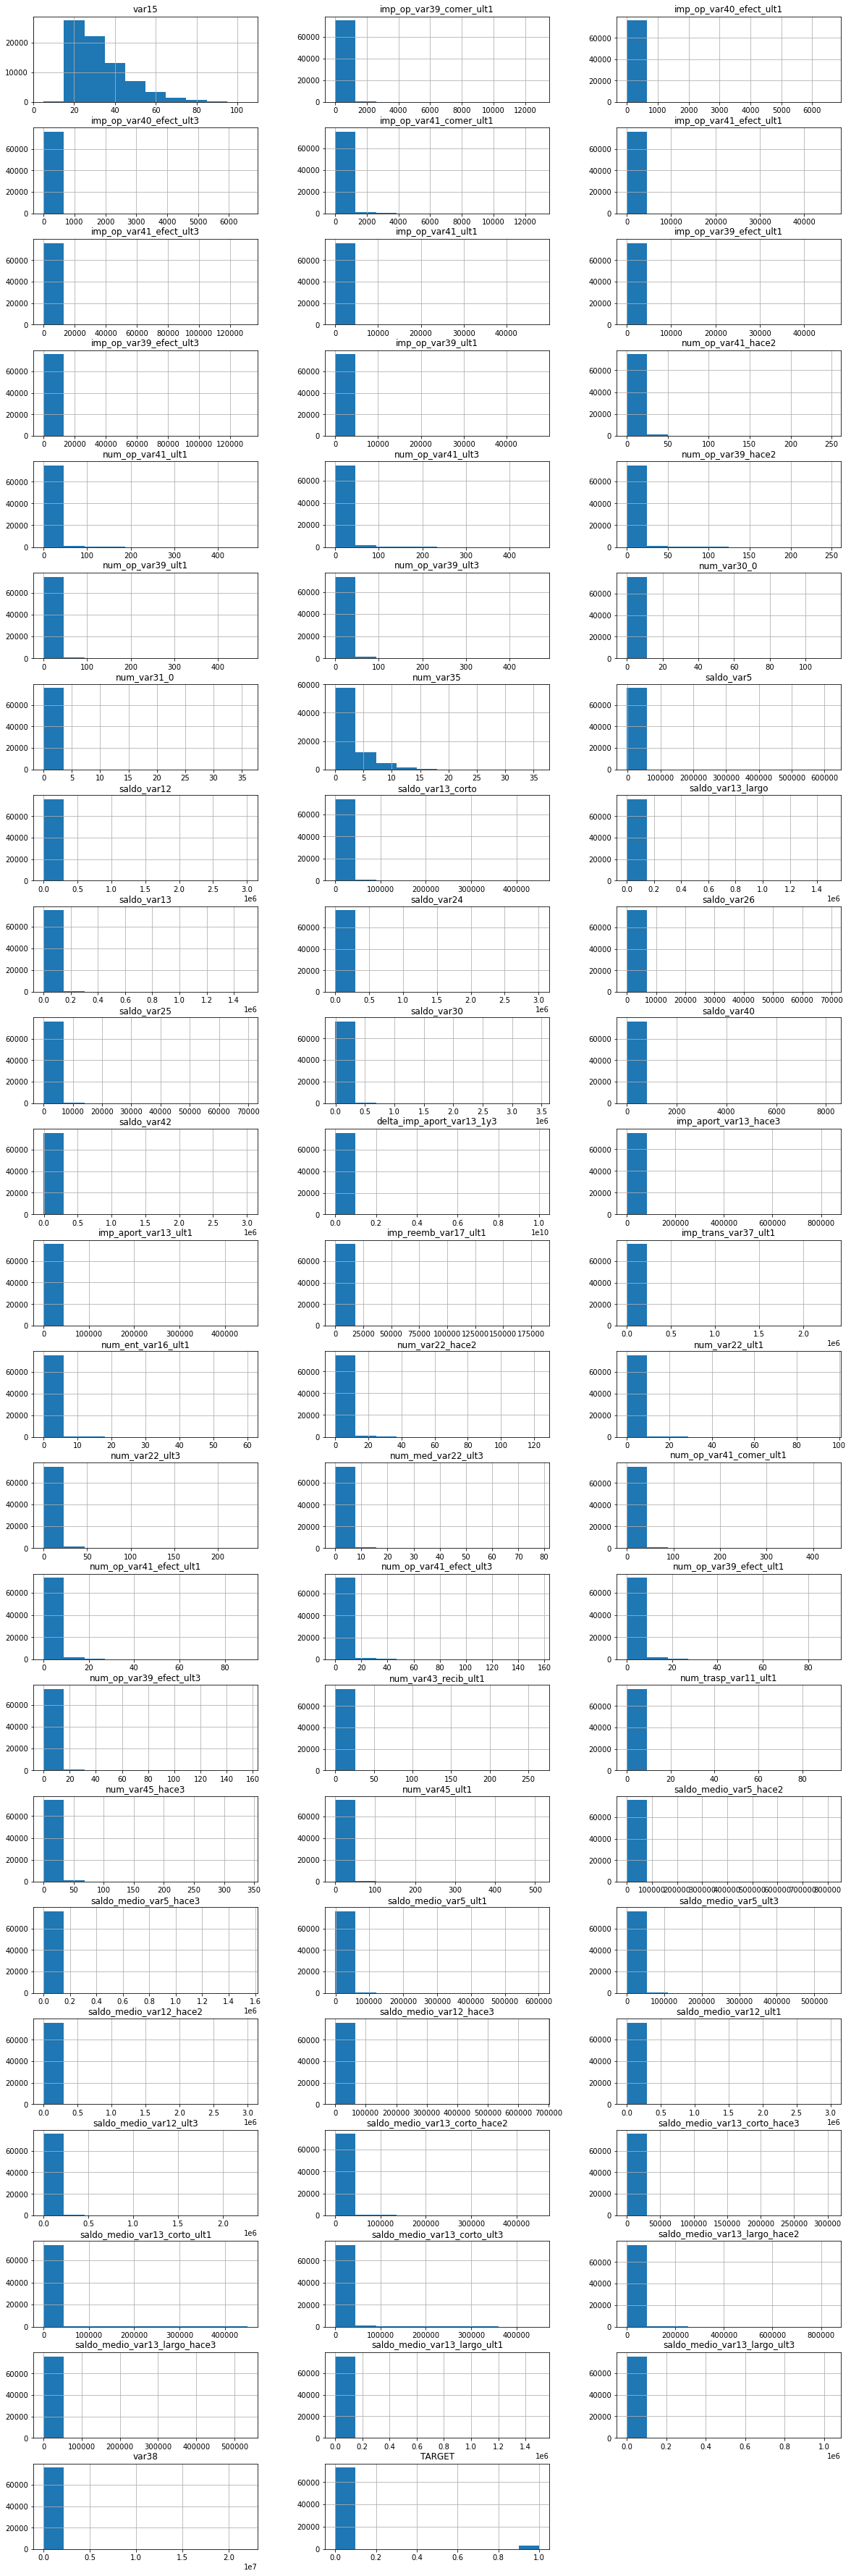

In [21]:
# Histograma das variáveis numéricas
clientes_aed_num.hist(figsize=(20,70), layout=(25,3))
plt.show()

#### Resultado: De acordo com o histograma as variáveis não estão em uma distribuição normal e a variável TARGET está totalmente desbalanceada

#### Teste de hipótese (Distribuição normal)

In [22]:
# Função para testar distribuição normal das variáveis
def teste_distribuicao_normal(variable):
    alpha = 0.05
    k2, p = normaltest(variable)
    
    print("Variavel:", variable.name)
    if p < alpha:
        print("Rejeitar H0, variável não tem uma distribuição normal. P-Value:", p, "\n")
        return False
    else:
        print("Falha ao rejeitar a H0, variável tem uma distribuição normal. P-Value:", p, "\n")
        return True

<p>Teste de hipótese:</p>
<p>H0: Variável tem uma distribuição normal</p>
<p>Ha: Variável não tem uma distribuição normal</p>

In [23]:
# Percorrer todas as variáveis numéricas para verificar se estão em uma distribuição normal
var_dnormal = clientes_aed_num.drop("TARGET", axis = 1).apply(teste_distribuicao_normal, axis = 0)

Variavel: var15
Rejeitar H0, variável não tem uma distribuição normal. P-Value: 0.0 

Variavel: imp_op_var39_comer_ult1
Rejeitar H0, variável não tem uma distribuição normal. P-Value: 0.0 

Variavel: imp_op_var40_efect_ult1
Rejeitar H0, variável não tem uma distribuição normal. P-Value: 0.0 

Variavel: imp_op_var40_efect_ult3
Rejeitar H0, variável não tem uma distribuição normal. P-Value: 0.0 

Variavel: imp_op_var41_comer_ult1
Rejeitar H0, variável não tem uma distribuição normal. P-Value: 0.0 

Variavel: imp_op_var41_efect_ult1
Rejeitar H0, variável não tem uma distribuição normal. P-Value: 0.0 

Variavel: imp_op_var41_efect_ult3
Rejeitar H0, variável não tem uma distribuição normal. P-Value: 0.0 

Variavel: imp_op_var41_ult1
Rejeitar H0, variável não tem uma distribuição normal. P-Value: 0.0 

Variavel: imp_op_var39_efect_ult1
Rejeitar H0, variável não tem uma distribuição normal. P-Value: 0.0 

Variavel: imp_op_var39_efect_ult3
Rejeitar H0, variável não tem uma distribuição normal.

#### Resultado: As variáveis numéricas não estão com uma distribuição normal

#### Boxplot

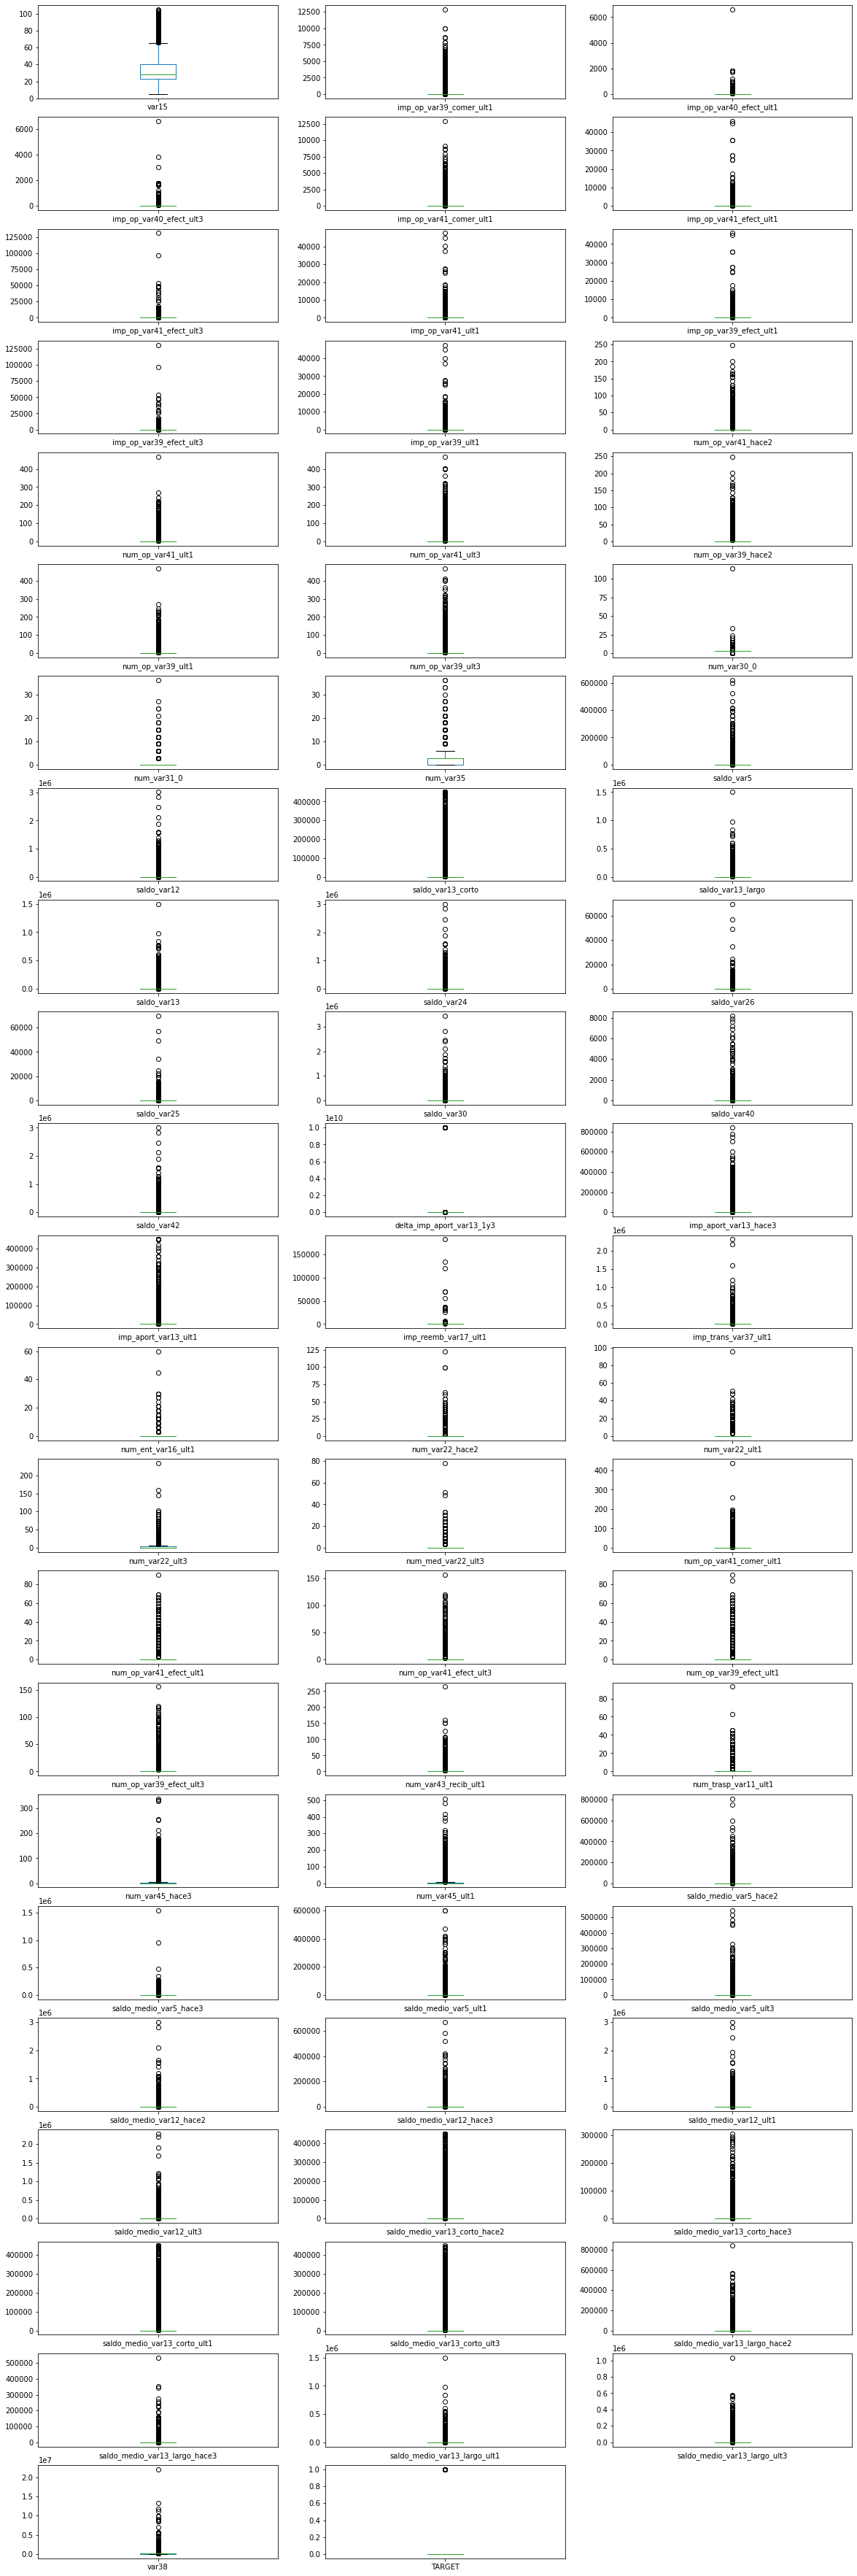

In [24]:
# Boxplot das variáveis numéricas
clientes_aed_num.plot(kind='box', layout=(25,3), subplots=True, figsize=(20,70))
plt.show()

#### Resultado: As variáveis estão com muitos outliers (Dados fora da curva)

#### Valores únicos de cada variável

In [25]:
# Valores únicos de cada variável
clientes_aed_num.apply(lambda i: len(np.unique(i)), axis = 0)

var15                              100
imp_op_var39_comer_ult1           7551
imp_op_var40_efect_ult1             23
imp_op_var40_efect_ult3             29
imp_op_var41_comer_ult1           7421
imp_op_var41_efect_ult1            331
imp_op_var41_efect_ult3            454
imp_op_var41_ult1                 8032
imp_op_var39_efect_ult1            336
imp_op_var39_efect_ult3            462
imp_op_var39_ult1                 8149
num_op_var41_hace2                  51
num_op_var41_ult1                   68
num_op_var41_ult3                   96
num_op_var39_hace2                  50
num_op_var39_ult1                   71
num_op_var39_ult3                   99
num_var30_0                         11
num_var31_0                         11
num_var35                           13
saldo_var5                       11642
saldo_var12                       3059
saldo_var13_corto                  730
saldo_var13_largo                  229
saldo_var13                        859
saldo_var24              

#### Resultado: A variável "saldo_var30", "saldo_var42" e "saldo_medio_var5_hace2" tem muitos valores únicos, podemos aplicar técnicas de quantization na variável.

### 3.2 - Análise das variáveis categóricas

#### Correlação (Spearman)

In [26]:
# Matriz de correlação das variáveis categóricas
clientes_cor = clientes[variaveis_categoricas].corr(method="spearman")

In [27]:
# Correlação das variáveis preditoras com a variável target
target_cor = clientes_cor["TARGET"].abs()

# Exibir correlação das variáveis com a variável target
print( target_cor )

ind_var1_0                       0.001608
ind_var1                         0.009571
ind_var2_0                            NaN
ind_var2                              NaN
ind_var5_0                       0.032888
ind_var5                         0.135349
ind_var6_0                       0.002082
ind_var6                         0.001041
ind_var8_0                       0.046665
ind_var8                         0.027926
ind_var12_0                      0.038215
ind_var12                        0.034255
ind_var13_0                      0.039471
ind_var13_corto_0                0.034337
ind_var13_corto                  0.034438
ind_var13_largo_0                0.019227
ind_var13_largo                  0.019040
ind_var13_medio_0                0.001041
ind_var13_medio                  0.001041
ind_var13                        0.039612
ind_var14_0                      0.020046
ind_var14                        0.007384
ind_var17_0                      0.005442
ind_var17                        0

#### Resultado: Variáveis preditoras tem uma correlação muito fraca com a variável "TARGET"

In [28]:
# Filtrar as variáveis com a correlação absoluta maior ou igual a 0.025 com a variável "TARGET"
variaveis_categoricas_cor = target_cor[ target_cor > 0.025].keys().values

# Exibir variáveis com mais correlação com a variável "TARGET"
print( variaveis_categoricas_cor )

['ind_var5_0' 'ind_var5' 'ind_var8_0' 'ind_var8' 'ind_var12_0' 'ind_var12'
 'ind_var13_0' 'ind_var13_corto_0' 'ind_var13_corto' 'ind_var13'
 'ind_var24_0' 'ind_var24' 'ind_var30' 'ind_var39_0' 'ind_var41_0'
 'num_var4' 'num_var5_0' 'num_var5' 'num_var8_0' 'num_var8' 'num_var12_0'
 'num_var12' 'num_var13_0' 'num_var13_corto_0' 'num_var13_corto'
 'num_var13' 'num_var24_0' 'num_var24' 'num_var30' 'num_var39_0'
 'num_var41_0' 'num_var42_0' 'num_var42' 'var36' 'num_aport_var13_hace3'
 'num_meses_var5_ult3' 'num_meses_var8_ult3' 'num_meses_var12_ult3'
 'num_meses_var13_corto_ult3' 'num_op_var40_efect_ult1'
 'num_op_var40_efect_ult3' 'TARGET']


#### Resultado: Essas são as variáveis que contem valor da correlação absoluta acima de 0.025 com a variável TARGET

In [29]:
# Filtrar dataset com as variáveis com maior correlação
clientes_aed_cat = clientes[variaveis_categoricas_cor]

In [30]:
# Visualizar dataset com as variáveis com maior correlação
clientes_aed_cat.head()

,ind_var5_0,ind_var5,ind_var8_0,ind_var8,ind_var12_0,ind_var12,ind_var13_0,ind_var13_corto_0,ind_var13_corto,ind_var13,ind_var24_0,ind_var24,ind_var30,ind_var39_0,ind_var41_0,num_var4,num_var5_0,num_var5,num_var8_0,num_var8,num_var12_0,num_var12,num_var13_0,num_var13_corto_0,num_var13_corto,num_var13,num_var24_0,num_var24,num_var30,num_var39_0,num_var41_0,num_var42_0,num_var42,var36,num_aport_var13_hace3,num_meses_var5_ult3,num_meses_var8_ult3,num_meses_var12_ult3,num_meses_var13_corto_ult3,num_op_var40_efect_ult1,num_op_var40_efect_ult3,TARGET
0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,3,0,0,0,0,0,0,0,0,0,0,0,0,3,3,3,0,99,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,1,1,1,1,0,0,1,1,1,1,3,0,0,0,0,0,3,3,3,3,0,0,3,3,3,3,0,3,3,1,0,0,3,0,0,0
2,1,1,0,0,0,0,0,0,0,0,0,0,1,1,1,1,3,3,0,0,0,0,0,0,0,0,0,0,3,3,3,3,3,99,0,3,0,0,0,0,0,0
3,1,1,0,0,0,0,0,0,0,0,0,0,1,1,1,3,3,3,0,0,0,0,0,0,0,0,0,0,3,3,3,3,3,2,0,2,0,0,0,0,0,0
4,1,0,0,0,1,1,0,0,0,0,1,1,1,1,1,1,3,0,0,0,3,3,0,0,0,0,3,3,3,3,3,6,3,1,0,3,0,1,0,0,0,0


In [31]:
# Visualizar sumário do dataset com as variáveis com maior correlação
clientes_aed_cat.describe()

,ind_var5_0,ind_var5,ind_var8_0,ind_var8,ind_var12_0,ind_var12,ind_var13_0,ind_var13_corto_0,ind_var13_corto,ind_var13,ind_var24_0,ind_var24,ind_var30,ind_var39_0,ind_var41_0,num_var4,num_var5_0,num_var5,num_var8_0,num_var8,num_var12_0,num_var12,num_var13_0,num_var13_corto_0,num_var13_corto,num_var13,num_var24_0,num_var24,num_var30,num_var39_0,num_var41_0,num_var42_0,num_var42,var36,num_aport_var13_hace3,num_meses_var5_ult3,num_meses_var8_ult3,num_meses_var12_ult3,num_meses_var13_corto_ult3,num_op_var40_efect_ult1,num_op_var40_efect_ult3,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.00000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000
mean,0.958024,0.663760,0.032833,0.028598,0.067522,0.045462,0.052249,0.042936,0.041476,0.050855,0.042370,0.037885,0.732833,0.880755,0.879282,1.079440,2.894041,1.999171,0.09854,0.085793,0.211247,0.138003,0.167719,0.130308,0.124507,0.159826,0.127664,0.113773,2.382873,2.724941,2.699250,3.204144,2.217995,40.449079,0.075888,1.979979,0.053604,0.102052,0.098921,0.002486,0.003670,0.039569
std,0.200535,0.472425,0.178202,0.166674,0.250925,0.208316,0.222531,0.202714,0.199390,0.219703,0.201434,0.190919,0.442483,0.324079,0.325802,0.909566,0.656479,1.431902,0.53493,0.500022,0.890236,0.637259,0.745822,0.618826,0.598746,0.713022,0.608482,0.573662,1.642787,1.139159,1.105297,0.944123,1.497703,47.362719,0.552499,1.298924,0.334908,0.487687,0.486064,0.147172,0.202068,0.194945
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,3.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,3.000000,3.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,3.000000,3.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,3.000000,3.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,3.000000,3.000000,3.000000,3.000000,99.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.000000,15.000000,15.000000,6.00000,3.000000,111.000000,15.000000,18.000000,6.000000,6.000000,18.000000,9.000000,6.000000,33.000000,33.000000,33.000000,114.000000,18.000000,99.000000,24.000000,3.000000,3.000000,3.000000,3.000000,24.000000,24.000000,1.000000


In [32]:
# Visualizar moda
clientes_aed_cat.mode()

,ind_var5_0,ind_var5,ind_var8_0,ind_var8,ind_var12_0,ind_var12,ind_var13_0,ind_var13_corto_0,ind_var13_corto,ind_var13,ind_var24_0,ind_var24,ind_var30,ind_var39_0,ind_var41_0,num_var4,num_var5_0,num_var5,num_var8_0,num_var8,num_var12_0,num_var12,num_var13_0,num_var13_corto_0,num_var13_corto,num_var13,num_var24_0,num_var24,num_var30,num_var39_0,num_var41_0,num_var42_0,num_var42,var36,num_aport_var13_hace3,num_meses_var5_ult3,num_meses_var8_ult3,num_meses_var12_ult3,num_meses_var13_corto_ult3,num_op_var40_efect_ult1,num_op_var40_efect_ult3,TARGET
0,1,1,0,0,0,0,0,0,0,0,0,0,1,1,1,1,3,3,0,0,0,0,0,0,0,0,0,0,3,3,3,3,3,99,0,3,0,0,0,0,0,0


#### Barplot

Barplot de cada variável com stack da variável "TARGET"

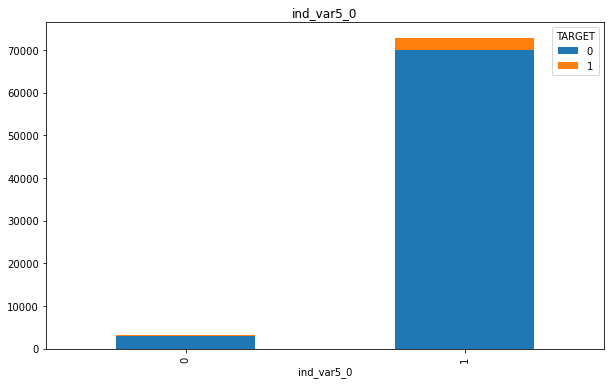

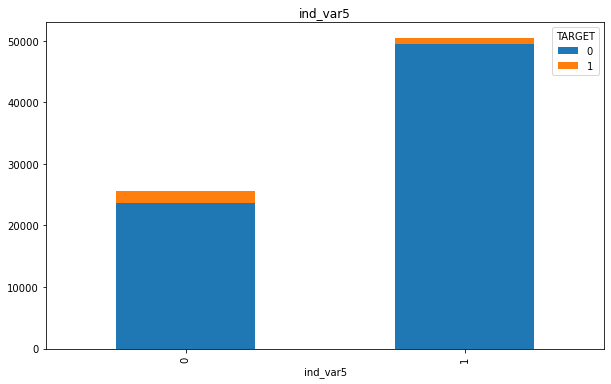

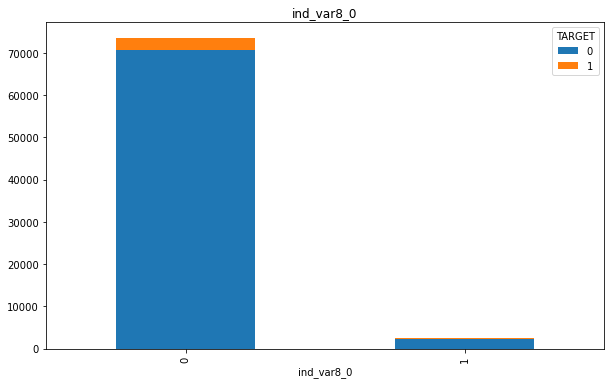

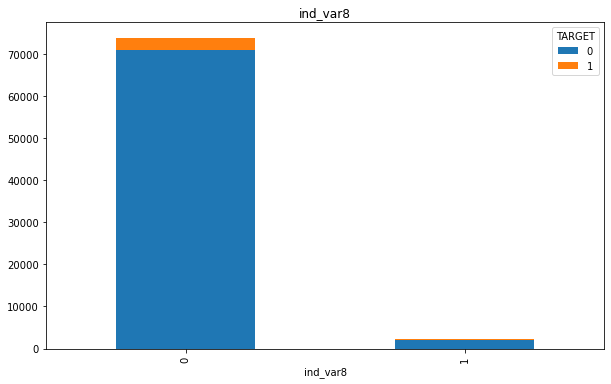

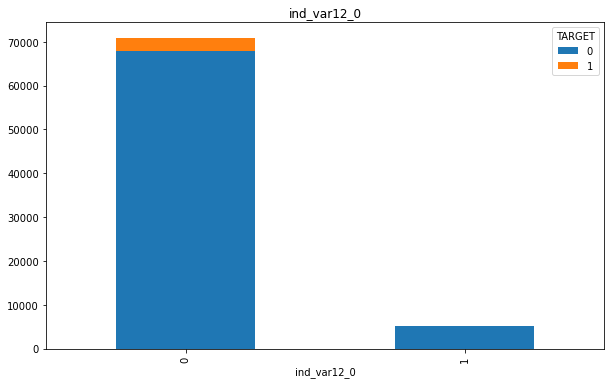

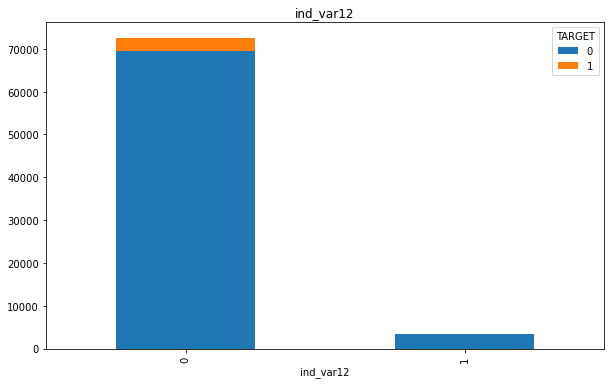

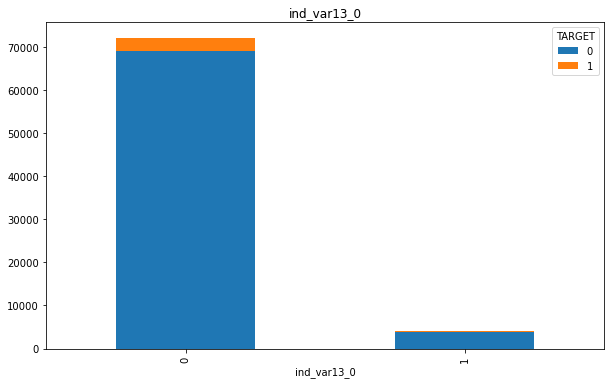

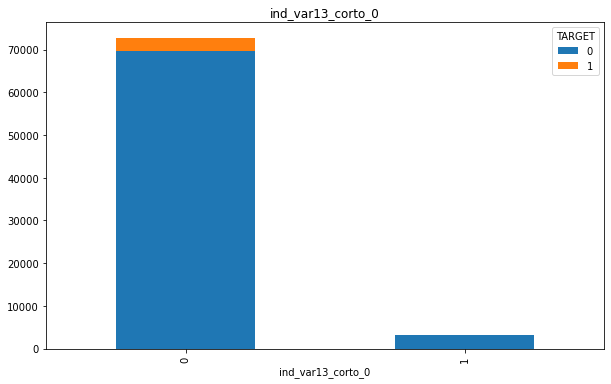

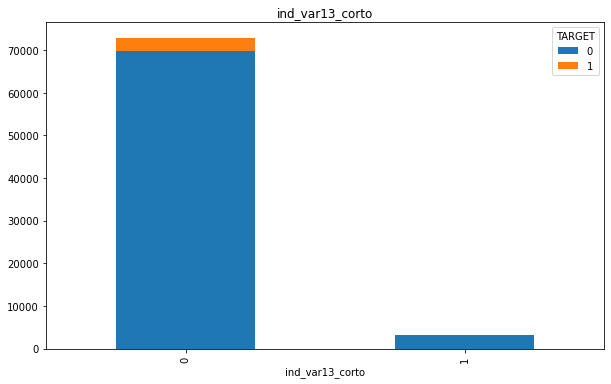

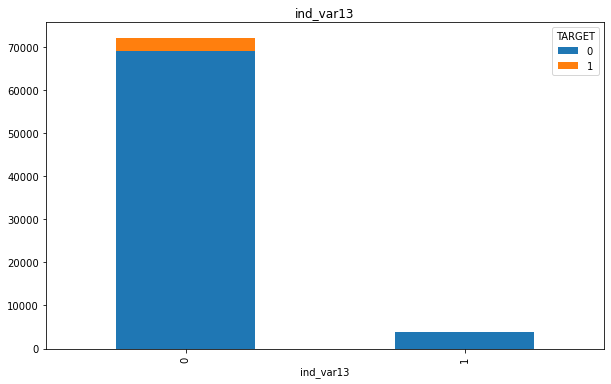

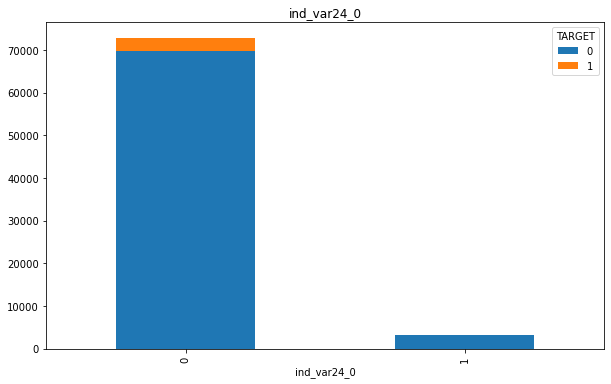

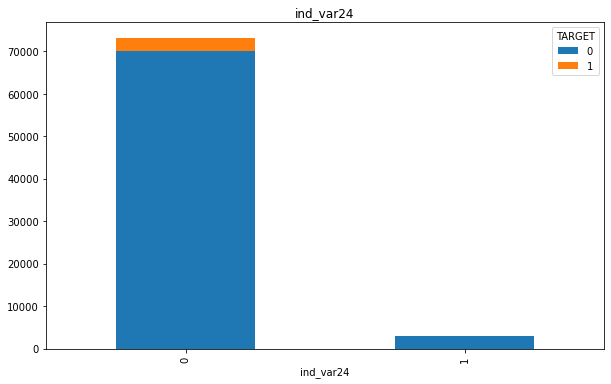

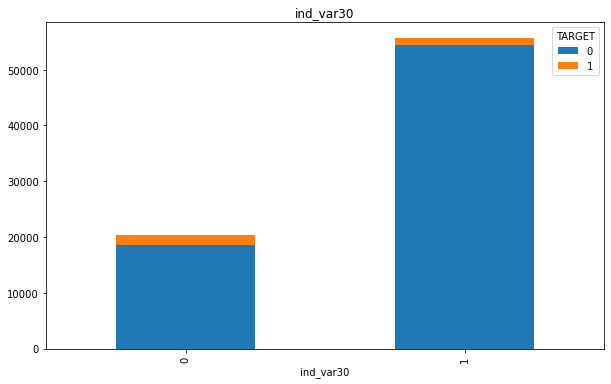

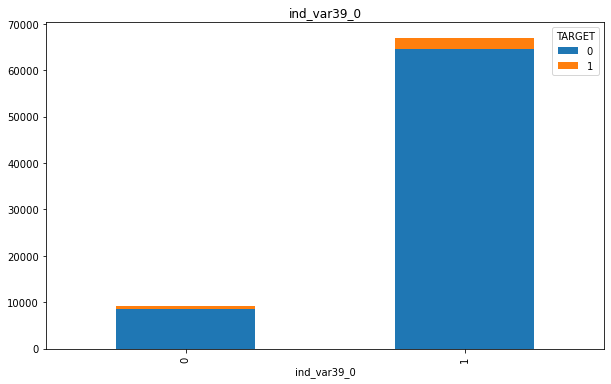

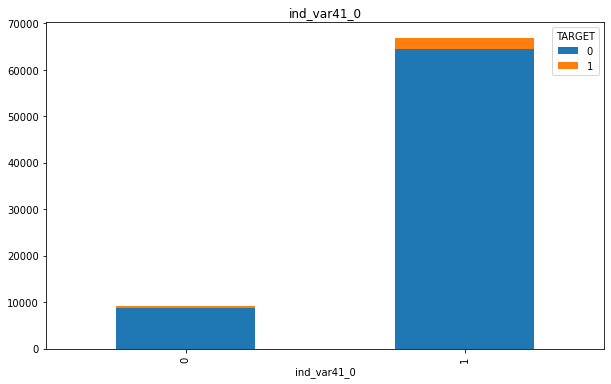

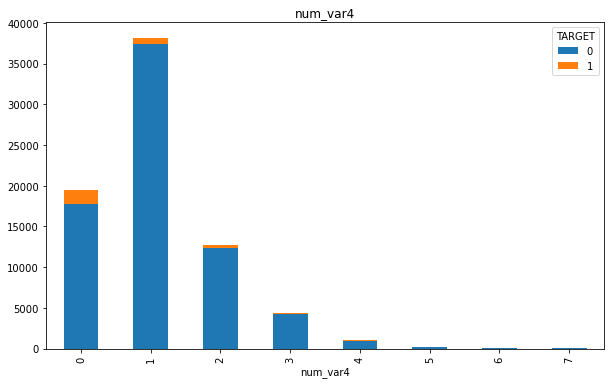

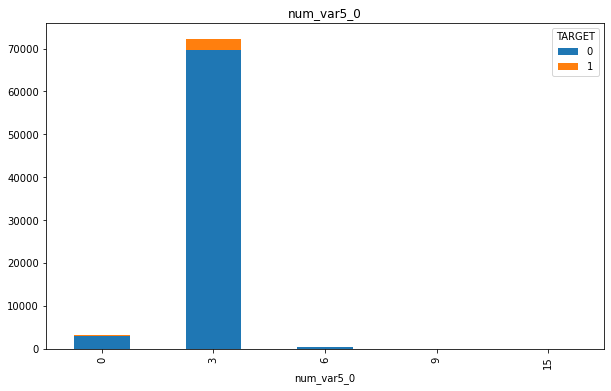

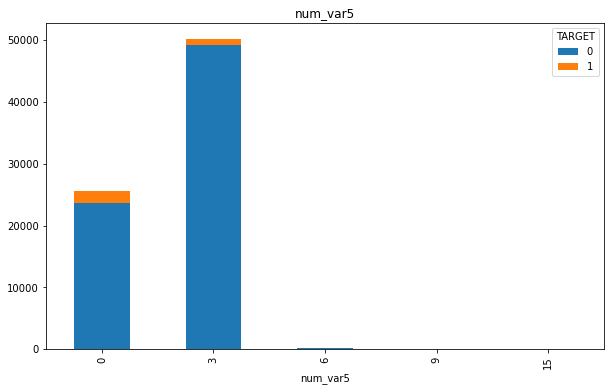

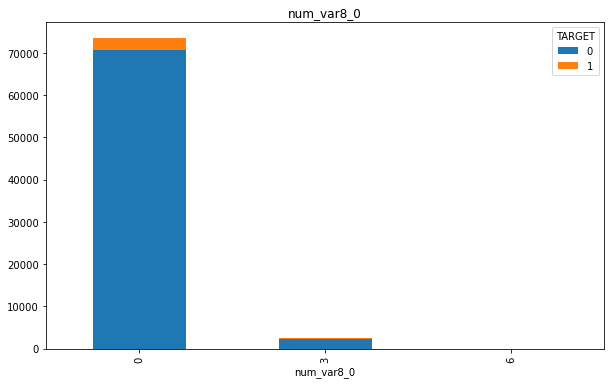

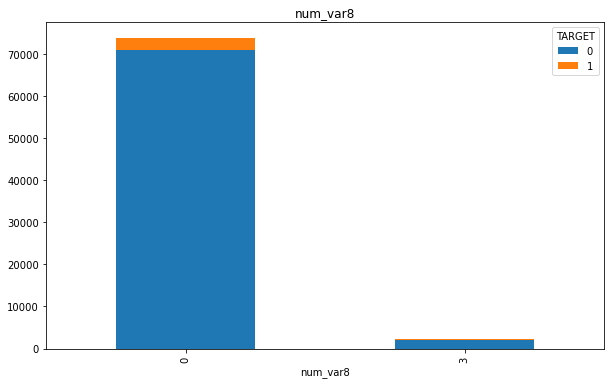

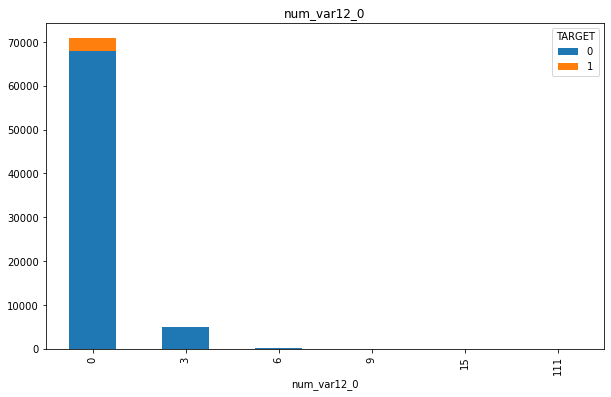

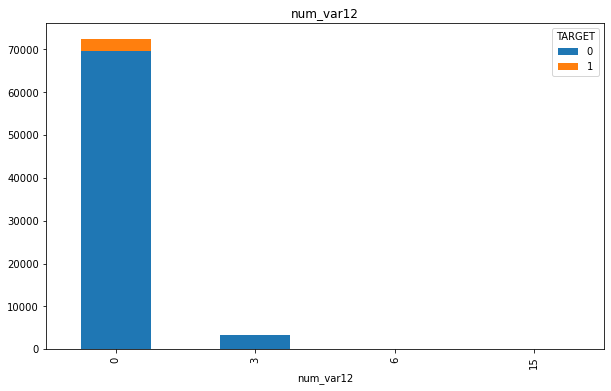

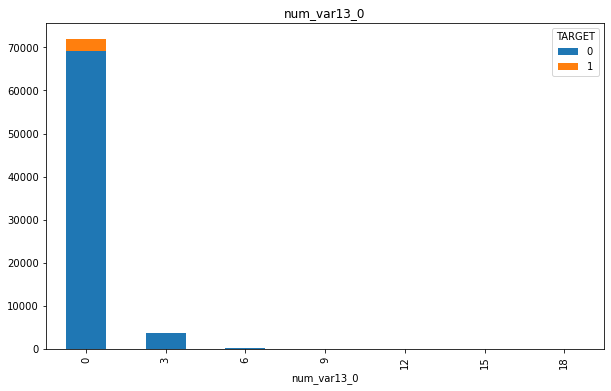

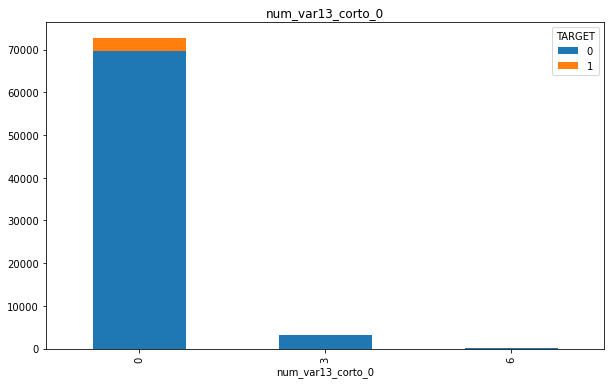

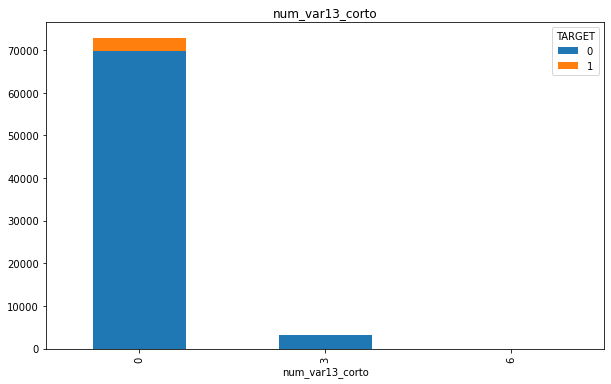

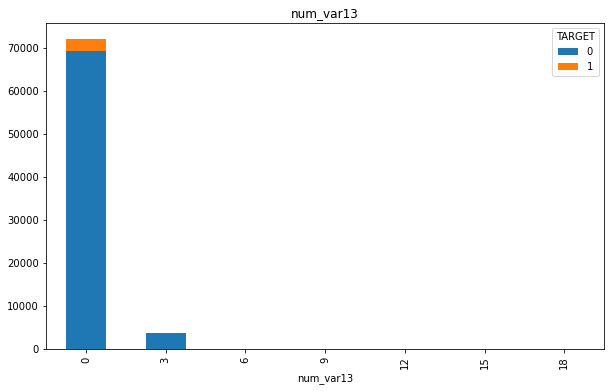

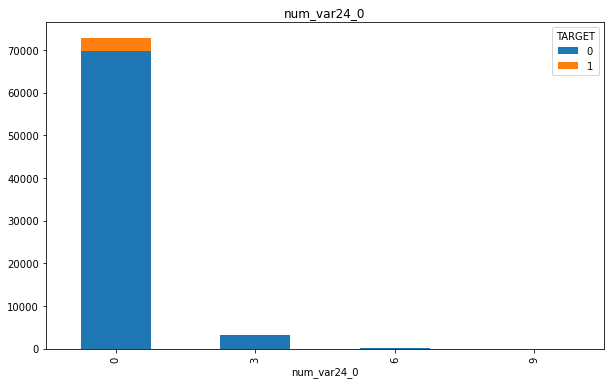

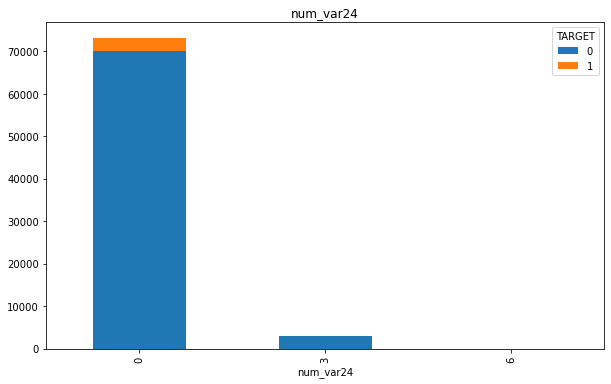

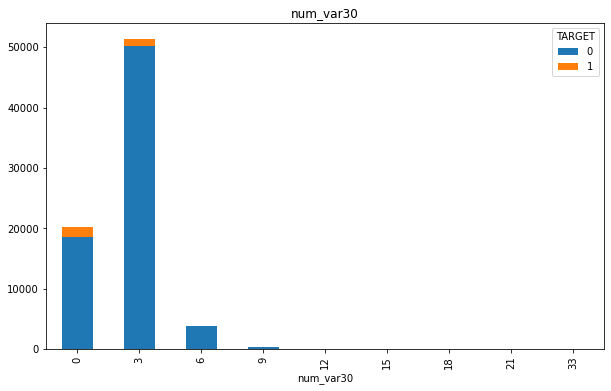

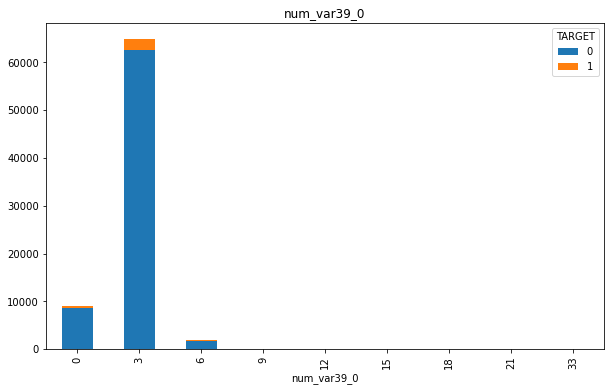

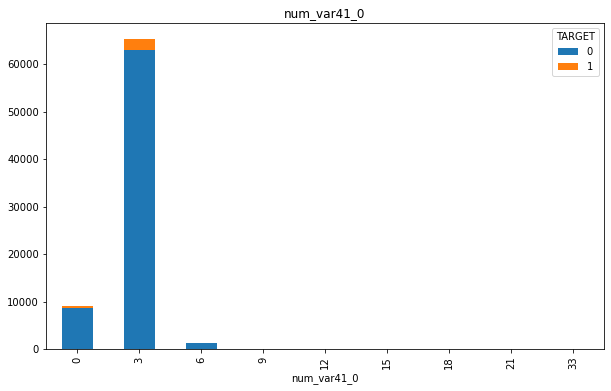

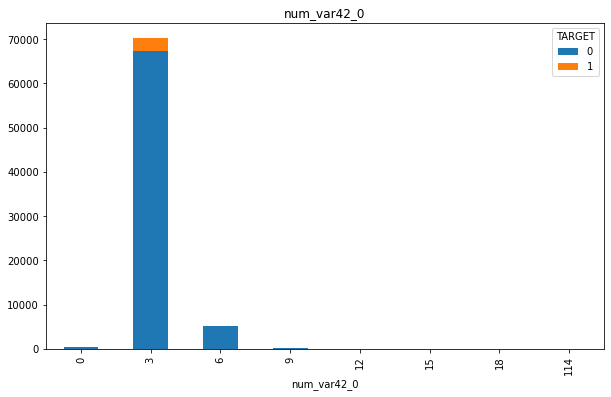

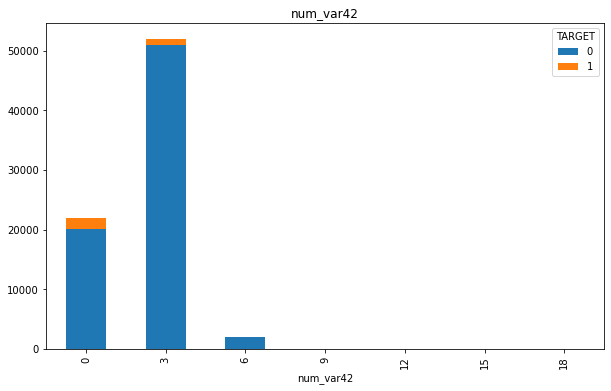

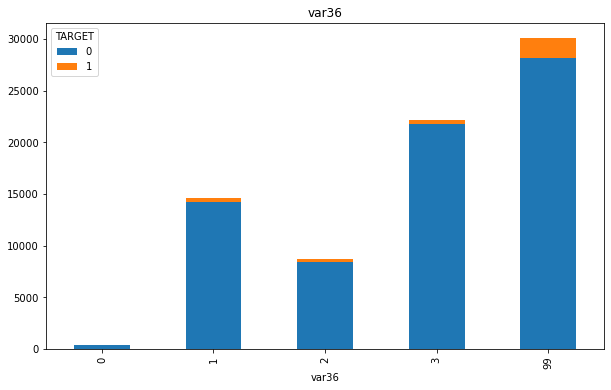

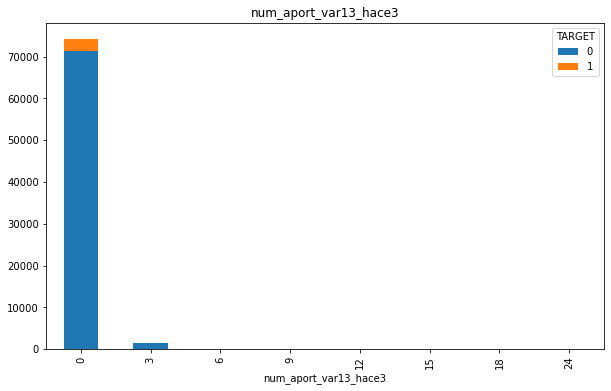

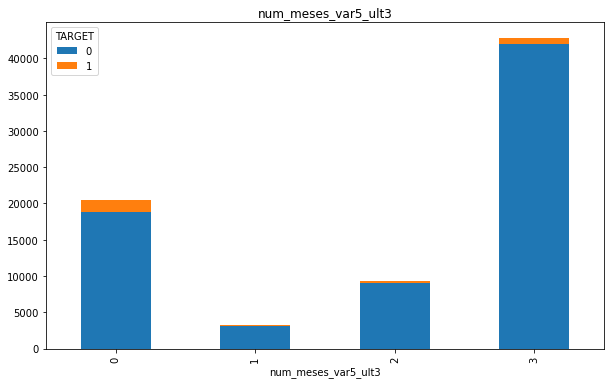

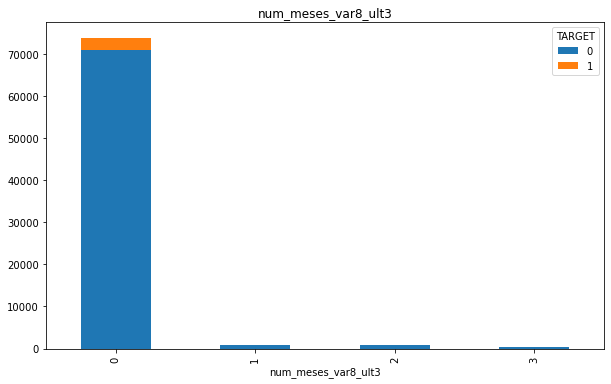

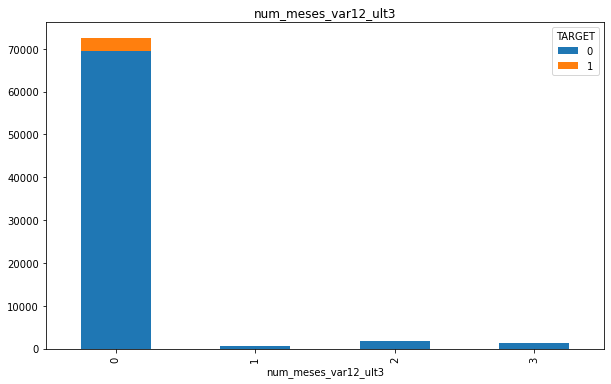

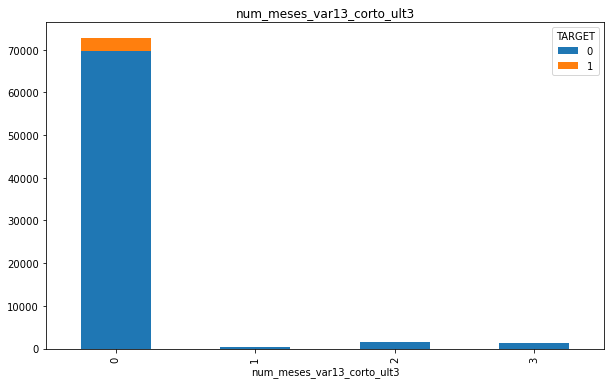

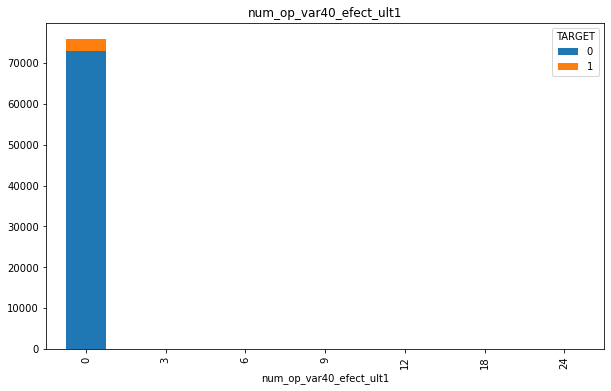

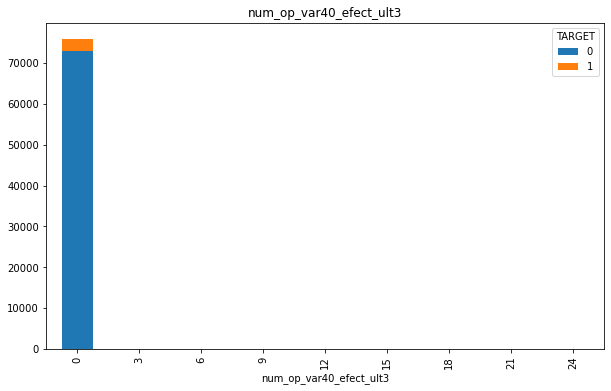

In [33]:
for i in clientes_aed_cat.drop("TARGET", axis = 1).columns:
    pd.crosstab(clientes_aed_cat[i], clientes_aed_cat["TARGET"]).plot(kind = "bar",
                                                                     stacked = True,
                                                                     figsize = (10,6),
                                                                     title = i)

#### Proporção de cada categoria das variáveis preditoras com a variavel "TARGET"

In [34]:
for i in clientes_aed_cat.drop("TARGET", axis = 1).columns:
    print("Variável:", i)
    print( pd.crosstab(clientes_aed_cat[i], clientes_aed_cat["TARGET"], normalize=True) )
    print("\n")

Variável: ind_var5_0
TARGET             0         1
ind_var5_0                    
0           0.039029  0.002947
1           0.921402  0.036622


Variável: ind_var5
TARGET           0         1
ind_var5                    
0         0.310471  0.025770
1         0.649961  0.013799


Variável: ind_var8_0
TARGET             0         1
ind_var8_0                    
0           0.930518  0.036648
1           0.029913  0.002920


Variável: ind_var8
TARGET           0         1
ind_var8                    
0         0.933873  0.037530
1         0.026559  0.002039


Variável: ind_var12_0
TARGET              0         1
ind_var12_0                    
0            0.893712  0.038766
1            0.066719  0.000802


Variável: ind_var12
TARGET            0         1
ind_var12                    
0          0.915378  0.039161
1          0.045054  0.000408


Variável: ind_var13_0
TARGET              0         1
ind_var13_0                    
0            0.908537  0.039213
1            0.05189



Variável: num_op_var40_efect_ult3
TARGET                          0         1
num_op_var40_efect_ult3                    
0                        0.959997  0.039411
3                        0.000250  0.000079
6                        0.000105  0.000053
9                        0.000013  0.000013
12                       0.000013  0.000000
15                       0.000000  0.000013
18                       0.000013  0.000000
21                       0.000013  0.000000
24                       0.000026  0.000000




#### Resultado: O dataset contem muitos dados com a variável TARGET igual á 0

#### Countplot da variável TARGET

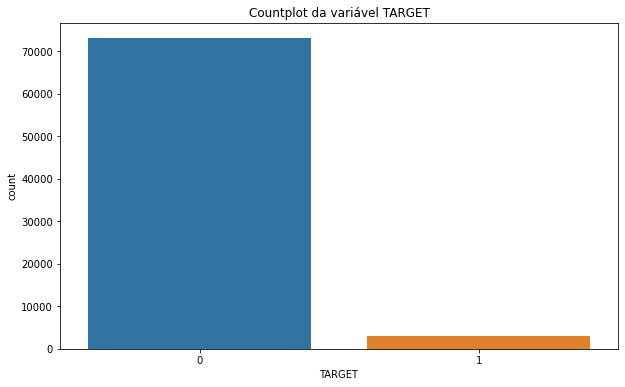

In [35]:
plt.figure(figsize=(10,6))
sns.countplot(x = "TARGET", data = clientes_aed_cat, )
plt.title("Countplot da variável TARGET")
plt.show()

#### Resultado: Confirmando a informação que já recolhemos na análise de variáveis numéricas, a variável "TARGET" está desbalanceada

## 4.0 - Principal Component Analysis e Machine Learning

De acordo com a análise exploratória realizada nos passos anteriores, foi verificado que as variáveis preditoras tem uma fraca correlação com a variável target, vamos utilizar o PCA para agrupar as variáveis em 10 componentes e realizar o treinamento do modelo de machine learning.

In [36]:
# Separar variáveis preditoras e variável target
x = clientes.drop("TARGET", axis = 1)
y = clientes["TARGET"]

In [37]:
# Normalizar as variáveis numéricas no dataset de treino
# OBS: Slicing utilizado para remover variável target da normalização.
x[variaveis_numericas[0:-1]] = StandardScaler().fit_transform(x[variaveis_numericas[0:-1]])

In [38]:
# Separar dados de treino e teste
treino_x, teste_x, treino_y, teste_y = train_test_split(x, y, test_size=0.33, random_state=42)

In [39]:
# Balancear classe da variável target nos dados de treino
treino_x_balanceado, treino_y_balanceado = balancear_classe(treino_x, treino_y)

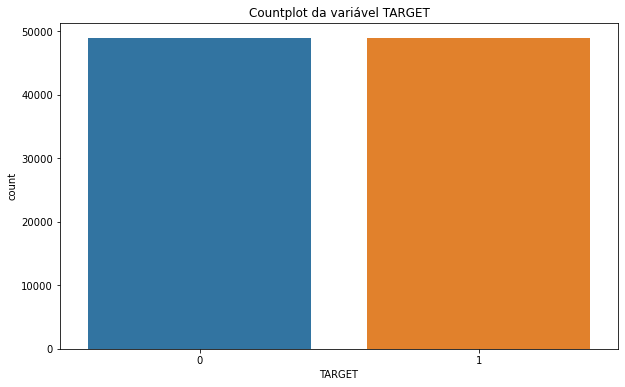

In [40]:
# Countplot da variável TARGET
plt.figure(figsize=(10,6))
sns.countplot(x = treino_y_balanceado)
plt.title("Countplot da variável TARGET")
plt.show()

#### Resultado: Variável TARGET foi balanceada com o método SMOTE

In [41]:
# Realizando PCA nos dados X
pca = PCA(n_components=10)
treino_x_balanceado = pca.fit_transform(treino_x_balanceado)
teste_x = pca.fit_transform(teste_x)

In [42]:
# Utilizar a função para obter a lista com modelos de machine learning que vão ser treinados
modelos = obter_modelos()

In [43]:
# Lista com as métricas de cada modelo
metricas = []

# Treinar o modelo de machine learning
for nome, modelo in modelos:
    kfold = KFold(n_splits=5)
    modelo_resultado = cross_val_score( modelo, treino_x_balanceado, treino_y_balanceado, cv = kfold, scoring = "accuracy" )
    metricas.append( (nome, modelo_resultado) )
    msg = "%s: %f (%f)" % (nome, modelo_resultado.mean(), modelo_resultado.std())
    print( msg )

LR: 0.502391 (0.426997)
LDA: 0.103382 (0.161294)
NB: 0.502309 (0.426743)
KNN: 0.770311 (0.040301)
CART: 0.115526 (0.163354)
SVM: 0.104088 (0.161032)


In [44]:
# Treinar o modelo KNN
modelo_knn_pca = KNeighborsClassifier()
modelo_knn_pca.fit(treino_x_balanceado, treino_y_balanceado)

# Avaliar o modelo KNN com dados de teste
previsao_knn_pca = modelo_knn_pca.predict(teste_x)
metricas_modelo("KNN", teste_y, previsao_knn_pca)

Modelo: KNN 

Confusion Matrix:
                Satisfeito  Não Satisfeito
Satisfeito           24083              13
Não Satisfeito         991               0

Relatório de classificação:
                precision    recall  f1-score   support

    Satisfeito       0.96      1.00      0.98     24096
Não Satisfeito       0.00      0.00      0.00       991

      accuracy                           0.96     25087
     macro avg       0.48      0.50      0.49     25087
  weighted avg       0.92      0.96      0.94     25087



In [45]:
# Treinar o modelo SVM
modelo_svm_pca = SVC()
modelo_svm_pca.fit(treino_x_balanceado, treino_y_balanceado)

# Avaliar o modelo SVM com dados de teste
previsao_svm_pca = modelo_svm_pca.predict(teste_x)
metricas_modelo("SVM", teste_y, previsao_svm_pca)

Modelo: SVM 

Confusion Matrix:
                Satisfeito  Não Satisfeito
Satisfeito             106           23990
Não Satisfeito           2             989

Relatório de classificação:
                precision    recall  f1-score   support

    Satisfeito       0.98      0.00      0.01     24096
Não Satisfeito       0.04      1.00      0.08       991

      accuracy                           0.04     25087
     macro avg       0.51      0.50      0.04     25087
  weighted avg       0.94      0.04      0.01     25087



#### Resultado: O resultado dos modelos não foi satisfatório, no modelo KNN, temos uma acurácia de 96%, porém o modelo não aprendeu corretamente a relação da classe 1 (Não satisfeito) e no modelo SVM foi o inverso do KNN, o modelo não aprendeu corretamente a relação da classe 0 (Satisfeito).
#### Vamos manipular os dados com objetivo de melhorar a performance dos modelos

## 5.0 - Manipulação dos dados

#### Filtrar dataset principal com as variáveis com mais correlação com a variável "TARGET", avaliadas na análise exploratória

In [46]:
variaveis = np.unique( np.concatenate((variaveis_categoricas_cor, variaveis_numericas_cor)) )
clientes_mesclado = clientes[variaveis]

In [47]:
clientes_mesclado.describe()

,TARGET,delta_imp_aport_var13_1y3,imp_aport_var13_hace3,imp_aport_var13_ult1,imp_op_var39_comer_ult1,imp_op_var39_efect_ult1,imp_op_var39_efect_ult3,imp_op_var39_ult1,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var41_comer_ult1,imp_op_var41_efect_ult1,imp_op_var41_efect_ult3,imp_op_var41_ult1,imp_reemb_var17_ult1,imp_trans_var37_ult1,ind_var12,ind_var12_0,ind_var13,ind_var13_0,ind_var13_corto,ind_var13_corto_0,ind_var24,ind_var24_0,ind_var30,ind_var39_0,ind_var41_0,ind_var5,ind_var5_0,ind_var8,ind_var8_0,num_aport_var13_hace3,num_ent_var16_ult1,num_med_var22_ult3,num_meses_var12_ult3,num_meses_var13_corto_ult3,num_meses_var5_ult3,num_meses_var8_ult3,num_op_var39_efect_ult1,num_op_var39_efect_ult3,num_op_var39_hace2,num_op_var39_ult1,num_op_var39_ult3,num_op_var40_efect_ult1,num_op_var40_efect_ult3,num_op_var41_comer_ult1,num_op_var41_efect_ult1,num_op_var41_efect_ult3,num_op_var41_hace2,num_op_var41_ult1,num_op_var41_ult3,num_trasp_var11_ult1,num_var12,num_var12_0,num_var13,num_var13_0,num_var13_corto,num_var13_corto_0,num_var22_hace2,num_var22_ult1,num_var22_ult3,num_var24,num_var24_0,num_var30,num_var30_0,num_var31_0,num_var35,num_var39_0,num_var4,num_var41_0,num_var42,num_var42_0,num_var43_recib_ult1,num_var45_hace3,num_var45_ult1,num_var5,num_var5_0,num_var8,num_var8_0,saldo_medio_var12_hace2,saldo_medio_var12_hace3,saldo_medio_var12_ult1,saldo_medio_var12_ult3,saldo_medio_var13_corto_hace2,saldo_medio_var13_corto_hace3,saldo_medio_var13_corto_ult1,saldo_medio_var13_corto_ult3,saldo_medio_var13_largo_hace2,saldo_medio_var13_largo_hace3,saldo_medio_var13_largo_ult1,saldo_medio_var13_largo_ult3,saldo_medio_var5_hace2,saldo_medio_var5_hace3,saldo_medio_var5_ult1,saldo_medio_var5_ult3,saldo_var12,saldo_var13,saldo_var13_corto,saldo_var13_largo,saldo_var24,saldo_var25,saldo_var26,saldo_var30,saldo_var40,saldo_var42,saldo_var5,var15,var36,var38
count,76020.000000,7.602000e+04,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.00000,7.602000e+04,76020.000000,7.602000e+04,7.602000e+04,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,7.602000e+04,76020.000000,7.602000e+04,76020.000000,76020.000000,7.602000e+04,7.602000e+04,76020.000000,7.602000e+04,7.602000e+04,76020.000000,76020.000000,7.602000e+04,76020.000000,7.602000e+04,76020.000000,76020.000000,76020.000000,7.602000e+04
mean,0.039569,4.867140e+07,2823.949089,619.585010,72.363067,68.618087,113.792410,140.403479,0.412946,0.567352,68.803937,68.205140,113.225058,137.242763,12.569401,1.932954e+03,0.045462,0.067522,0.050855,0.052249,0.041476,0.042936,0.037885,0.042370,0.732833,0.880755,0.879282,0.663760,0.958024,0.028598,0.032833,0.075888,0.187964,0.635872,0.102052,0.098921,1.979979,0.053604,0.721902,1.215825,1.621389,2.915864,4.632202,0.002486,0.003670,2.119811,0.719416,1.212155,1.601144,2.858840,4.553907,0.120679,0.138003,0.211247,0.159826,0.167719,0.124507,0.130308,1.298698,0.560655,3.044238,0.113773,0.127664,2.382873,3.371863,0.020126,3.299369,2.724941,1.079440,2.699250,2.217995,3.204144,0.814996,3.89

#### Sumário do dataset com as variáveis com maior correlação com a variável TARGET

#### Tratamento de outliers

In [48]:
# Função para remover outlier
def remover_outlier(valor):
    Q1 = np.percentile(valor, 25)
    Q3 = np.percentile(valor, 75)
    IQR = 1.5 * (Q3 - Q1)
    upper_tail = IQR + Q3
    lower_tail = Q1 - IQR
    valor = np.where(valor > upper_tail, np.nan, valor)
    valor = np.where(valor < lower_tail, np.nan, valor)
    return valor

In [49]:
# Copia do dataset mesclado com as melhores variáveis
clientes_mung = clientes_mesclado.copy()

In [50]:
# Retirando a variável target do array
variaveis_numericas_sem_target = np.delete(variaveis_numericas_cor, len(variaveis_numericas_cor)-1)

In [51]:
# Removendo os valores outliers das variáveis
clientes_mung[variaveis_numericas_sem_target] = clientes_mesclado[variaveis_numericas_sem_target].copy().apply(remover_outlier)
clientes_mung.dropna(inplace = True)

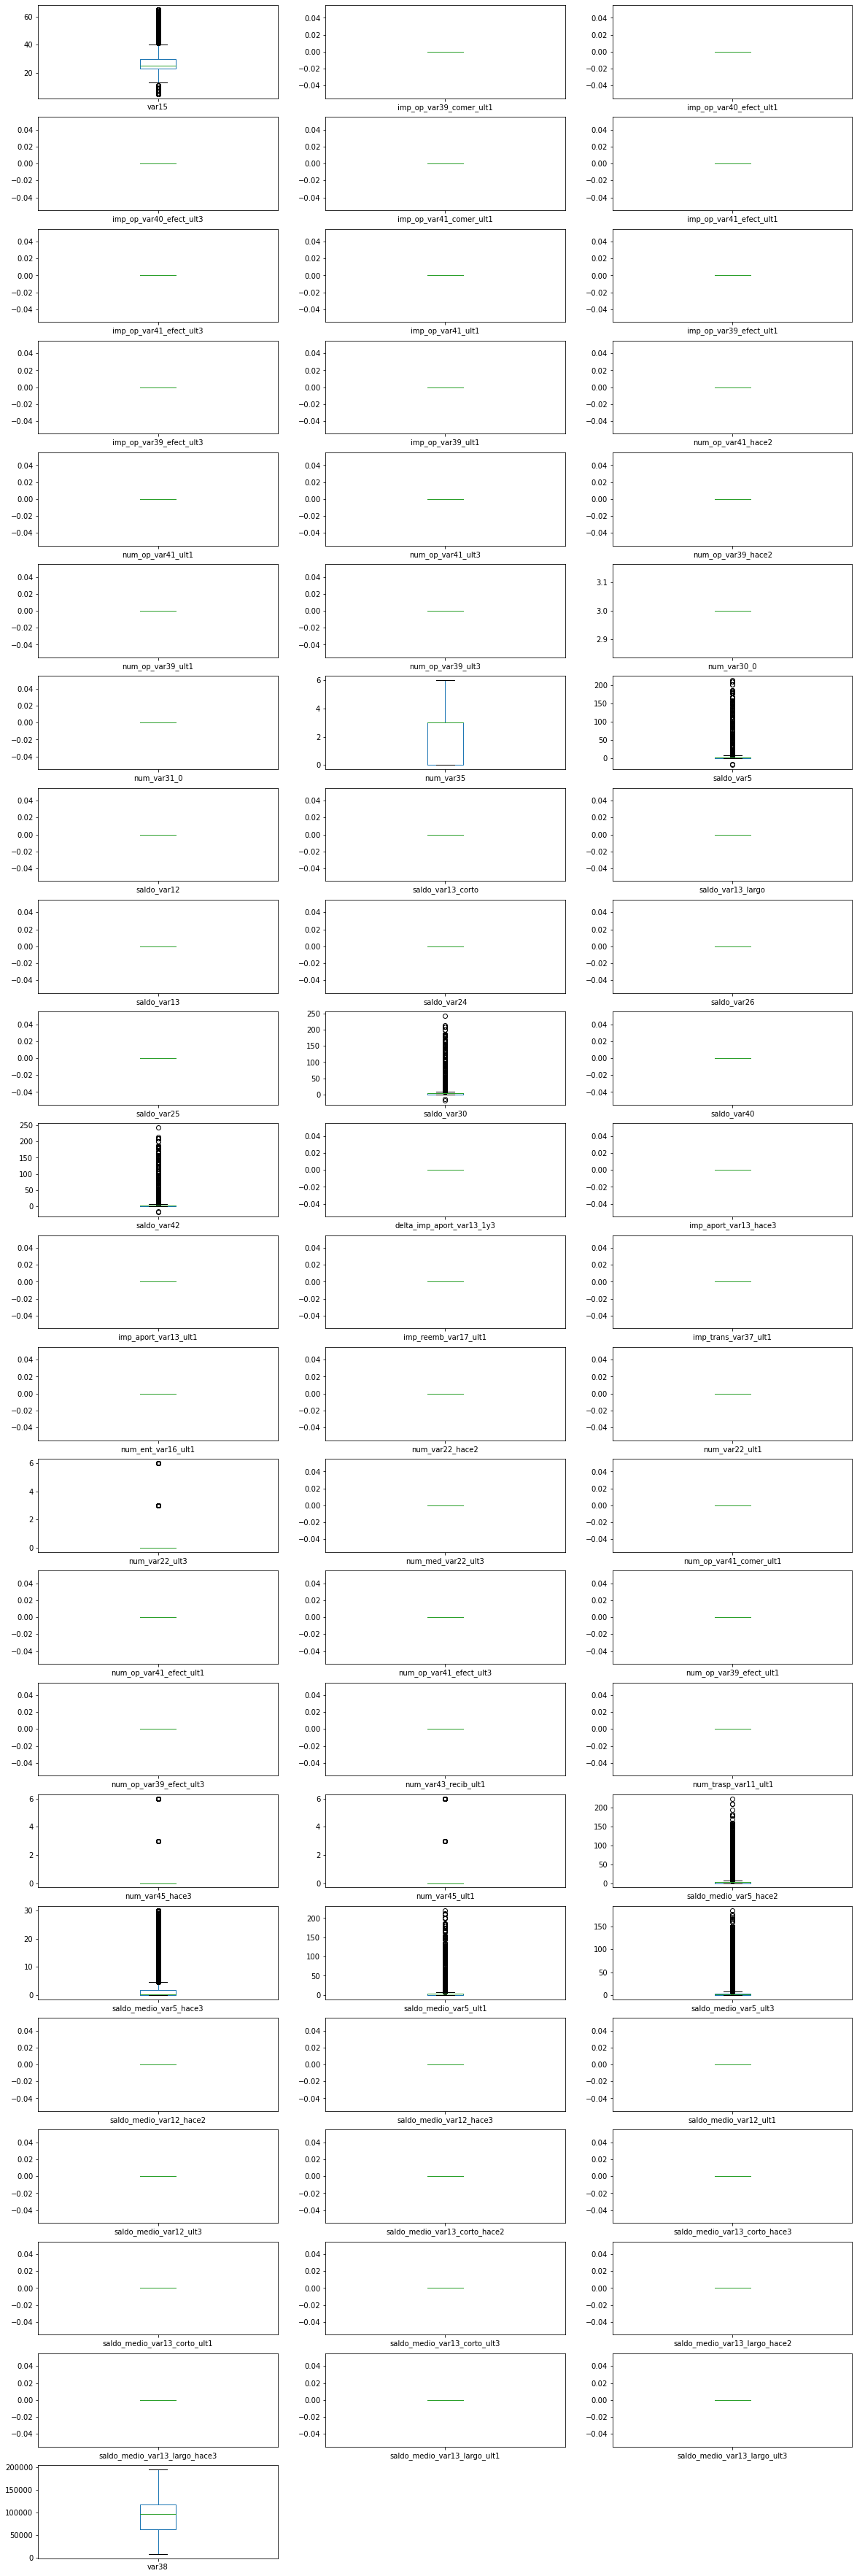

In [52]:
clientes_mung[variaveis_numericas_sem_target].plot(kind = "box", subplots = True, layout = (25,3), figsize = (20,70))
plt.show()

#### Resultado: Excluído outliers das variáveis numéricas, porém algumas variáveis ainda estão com outliers

In [53]:
clientes_mung.describe()

,TARGET,delta_imp_aport_var13_1y3,imp_aport_var13_hace3,imp_aport_var13_ult1,imp_op_var39_comer_ult1,imp_op_var39_efect_ult1,imp_op_var39_efect_ult3,imp_op_var39_ult1,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var41_comer_ult1,imp_op_var41_efect_ult1,imp_op_var41_efect_ult3,imp_op_var41_ult1,imp_reemb_var17_ult1,imp_trans_var37_ult1,ind_var12,ind_var12_0,ind_var13,ind_var13_0,ind_var13_corto,ind_var13_corto_0,ind_var24,ind_var24_0,ind_var30,ind_var39_0,ind_var41_0,ind_var5,ind_var5_0,ind_var8,ind_var8_0,num_aport_var13_hace3,num_ent_var16_ult1,num_med_var22_ult3,num_meses_var12_ult3,num_meses_var13_corto_ult3,num_meses_var5_ult3,num_meses_var8_ult3,num_op_var39_efect_ult1,num_op_var39_efect_ult3,num_op_var39_hace2,num_op_var39_ult1,num_op_var39_ult3,num_op_var40_efect_ult1,num_op_var40_efect_ult3,num_op_var41_comer_ult1,num_op_var41_efect_ult1,num_op_var41_efect_ult3,num_op_var41_hace2,num_op_var41_ult1,num_op_var41_ult3,num_trasp_var11_ult1,num_var12,num_var12_0,num_var13,num_var13_0,num_var13_corto,num_var13_corto_0,num_var22_hace2,num_var22_ult1,num_var22_ult3,num_var24,num_var24_0,num_var30,num_var30_0,num_var31_0,num_var35,num_var39_0,num_var4,num_var41_0,num_var42,num_var42_0,num_var43_recib_ult1,num_var45_hace3,num_var45_ult1,num_var5,num_var5_0,num_var8,num_var8_0,saldo_medio_var12_hace2,saldo_medio_var12_hace3,saldo_medio_var12_ult1,saldo_medio_var12_ult3,saldo_medio_var13_corto_hace2,saldo_medio_var13_corto_hace3,saldo_medio_var13_corto_ult1,saldo_medio_var13_corto_ult3,saldo_medio_var13_largo_hace2,saldo_medio_var13_largo_hace3,saldo_medio_var13_largo_ult1,saldo_medio_var13_largo_ult3,saldo_medio_var5_hace2,saldo_medio_var5_hace3,saldo_medio_var5_ult1,saldo_medio_var5_ult3,saldo_var12,saldo_var13,saldo_var13_corto,saldo_var13_largo,saldo_var24,saldo_var25,saldo_var26,saldo_var30,saldo_var40,saldo_var42,saldo_var5,var15,var36,var38
count,36268.000000,36268.0,36268.0,36268.0,36268.0,36268.0,36268.0,36268.0,36268.0,36268.0,36268.0,36268.0,36268.0,36268.0,36268.0,36268.0,36268.0,36268.000000,36268.0,36268.000000,36268.0,36268.0,36268.0,36268.0,36268.000000,36268.000000,36268.000000,36268.000000,36268.000000,36268.000000,36268.000000,36268.0,36268.0,36268.0,36268.0,36268.0,36268.000000,36268.000000,36268.0,36268.0,36268.0,36268.0,36268.0,36268.0,36268.0,36268.0,36268.0,36268.0,36268.0,36268.0,36268.0,36268.0,36268.0,36268.000000,36268.0,36268.000000,36268.0,36268.0,36268.0,36268.0,36268.000000,36268.0,36268.0,36268.000000,36268.0,36268.0,36268.000000,36268.000000,36268.000000,36268.000000,36268.000000,36268.000000,36268.0,36268.000000,36268.000000,36268.000000,36268.000000,36268.000000,36268.000000,36268.0,36268.0,36268.0,36268.0,36268.0,36268.0,36268.0,36268.0,36268.0,36268.0,36268.0,36268.0,36268.000000,36268.000000,36268.000000,36268.000000,36268.0,36268.0,36268.0,36268.0,36268.0,36268.0,36268.0,36268.000000,36268.0,36268.000000,36268.000000,36268.000000,36268.000000,36268.000000
mean,0.048858,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001599,0.0,0.000028,0.0,0.0,0.0,0.0,0.578003,0.823177,0.823177,0.577120,0.991921,0.000882,0.006452,0.0,0.0,0.0,0.0,0.0,1.683219,0.002261,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.004798,0.0,0.000083,0.0,0.0,0.0,0.0,0.109187,0.0,0.0,1.734008,3.0,0.0,1.741370,2.471104,0.580457,2.471269,1.733843,2.999917,0.0,0.392826,0.115143,1.731361,2.975764,0.002647,0.019356,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.166161,1.822803,9.634257,7.411375,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.647747,0.0,9.647747,9.620500,28.347028,60.750551,94533.772171
std,0.215575,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.039959,0.0,0.005251,0.0,0.0,0.0,0.0,0.493885,0.381524,0.381524,0.494023,0.089519,0.029691,0.080066,0.0,0.0,0.0,0.0,0.0,1.452547,0.077141,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.119876,0.0,0.015753,0.0,0.0,0.0,0.0,0.632473,0.0,0.0,1.481655,0.0,0.0,1.487997,1.147571,0.495999,1.147864,1.481681,0.015753,0.0,1.2

#### Resultado: Podemos verificar no sumário do dataset que muitas variáveis ficaram somente com valores zero, portanto vamos remover as variáveis que contem valores unicos.

In [54]:
# Função para retornar variaveis que tenham apenas um valor
def var_um_valor(df):
    lista_de_variaveis_com_valores_unicos = []
    for i in df.columns:
        if len( df[i].value_counts().index.values ) < 2:
            lista_de_variaveis_com_valores_unicos = np.append(lista_de_variaveis_com_valores_unicos, [i])
    return lista_de_variaveis_com_valores_unicos

In [55]:
variaveis_com_valores_unicos = var_um_valor(clientes_mung)

In [56]:
# Remover variáveis com apenas um valor do dataset
clientes_mung = clientes_mung.drop(variaveis_com_valores_unicos, axis = 1).reset_index().drop("index", axis = 1)

In [57]:
clientes_mung.head()

,TARGET,ind_var12_0,ind_var13_0,ind_var30,ind_var39_0,ind_var41_0,ind_var5,ind_var5_0,ind_var8,ind_var8_0,num_meses_var5_ult3,num_meses_var8_ult3,num_var12_0,num_var13_0,num_var22_ult3,num_var30,num_var35,num_var39_0,num_var4,num_var41_0,num_var42,num_var42_0,num_var45_hace3,num_var45_ult1,num_var5,num_var5_0,num_var8,num_var8_0,saldo_medio_var5_hace2,saldo_medio_var5_hace3,saldo_medio_var5_ult1,saldo_medio_var5_ult3,saldo_var30,saldo_var42,saldo_var5,var15,var36,var38
0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0.0,0,0.0,3,0,3,0,3,0.0,0.0,0,3,0,0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,23.0,99,39205.17
1,0,0,0,1,1,1,1,1,0,0,3,0,0,0,0.0,3,3.0,3,1,3,3,3,0.0,0.0,3,3,0,0,3.0,0.18,3.0,2.07,3.0,3.0,3.0,23.0,99,67333.77
2,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0.0,0,0.0,3,0,3,0,3,0.0,0.0,0,3,0,0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,23.0,99,87975.75
3,0,0,0,1,1,1,1,1,0,0,3,0,0,0,0.0,3,3.0,3,1,3,3,3,0.0,0.0,3,3,0,0,3.0,0.42,3.0,2.13,3.0,3.0,3.0,27.0,3,94956.66
4,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0.0,0,0.0,3,0,3,0,3,0.0,0.0,0,3,0,0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,45.0,99,101962.02


#### Resultado: Primeiras linhas do dataset com as variáveis com maior correlação e com mais de 1 valor nas variáveis.

In [58]:
# Atualizar valor das variaveis numericas, foram retiradas algumas variáveis durante a manipulação de dados.
variaveis_numericas_mung = [x for x in variaveis_numericas_sem_target if x not in variaveis_com_valores_unicos]

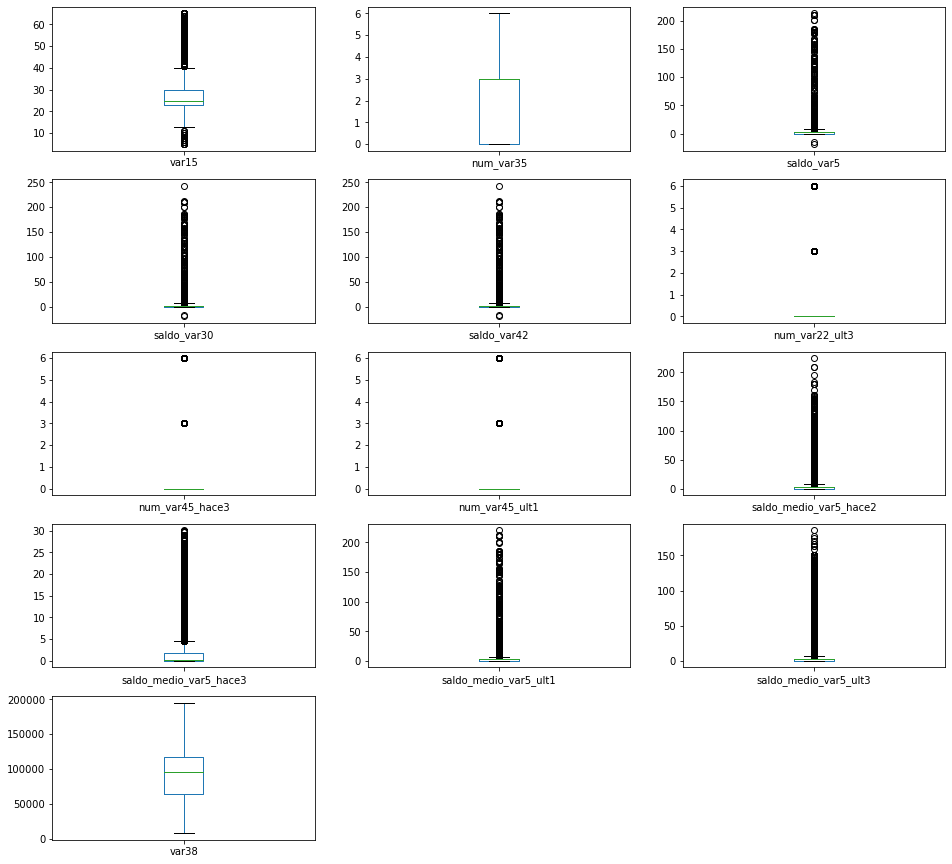

In [59]:
# Boxplot das variáveis numéricas
clientes_mung[variaveis_numericas_mung].plot(kind='box', layout=(9,3), subplots=True, figsize=(16,28))
plt.show()

#### Resultado: Ainda temos outliers em nossas variáveis numéricas, porém não temos como saber se são outliers naturais porque são dados anonimos do banco Santander

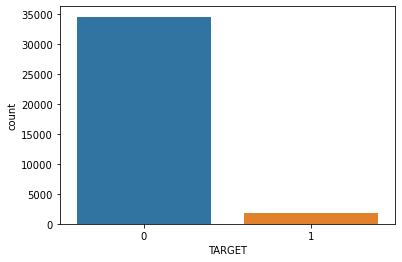

In [60]:
# Countplot da variável TARGET
sns.countplot(x = "TARGET", data = clientes_mung)
plt.show()

#### Resultado: Variável TARGET está desbalanceada

#### Separar variáveis preditoras da variável target

In [61]:
# Separar variáveis preditoras da variável target
x = clientes_mung.drop("TARGET", axis = 1)
y = clientes_mung["TARGET"]

#### Normalizar as variáveis numéricas

In [62]:
x[variaveis_numericas_mung] = StandardScaler().fit_transform(x[variaveis_numericas_mung])

#### Separar dados de treino e de teste

In [63]:
treino_x, teste_x, treino_y, teste_y = train_test_split(x, y, test_size=0.33, random_state=42)

In [64]:
treino_x.head()

,ind_var12_0,ind_var13_0,ind_var30,ind_var39_0,ind_var41_0,ind_var5,ind_var5_0,ind_var8,ind_var8_0,num_meses_var5_ult3,num_meses_var8_ult3,num_var12_0,num_var13_0,num_var22_ult3,num_var30,num_var35,num_var39_0,num_var4,num_var41_0,num_var42,num_var42_0,num_var45_hace3,num_var45_ult1,num_var5,num_var5_0,num_var8,num_var8_0,saldo_medio_var5_hace2,saldo_medio_var5_hace3,saldo_medio_var5_ult1,saldo_medio_var5_ult3,saldo_var30,saldo_var42,saldo_var5,var15,var36,var38
4043,0,0,1,1,1,1,1,0,0,3,0,0,0,-0.172638,3,0.845867,3,1,3,3,3,-0.324948,-0.173512,3,3,0,0,-0.255256,0.015162,-0.260276,-0.247672,-0.259671,-0.259671,-0.259056,-0.513695,3,-0.838179
25461,0,0,1,1,1,1,1,0,0,3,0,0,0,-0.172638,3,0.845867,3,1,3,3,3,-0.324948,4.347282,3,3,0,0,-0.255256,0.008393,-0.260276,-0.249230,-0.259671,-0.259671,-0.259056,-0.631867,3,-0.596336
17201,0,0,1,1,1,1,1,0,0,3,0,0,0,-0.172638,3,0.845867,3,1,3,3,3,-0.324948,-0.173512,3,3,0,0,-0.255256,-0.370677,-0.260276,-0.277260,-0.259671,-0.259671,-0.259056,-0.041009,3,2.435594
18305,0,0,0,1,1,0,1,0,0,0,0,0,0,-0.172638,0,-1.170294,3,0,3,0,3,-0.324948,-0.173512,0,3,0,0,-0.379445,-0.411291,-0.377973,-0.384709,-0.376856,-0.376856,-0.376445,-0.631867,99,-0.219802
21597,0,0,0,1,1,0,1,0,0,0,0,0,0,-0.172638,0,-1.170294,3,0,3,0,3,-0.324948,-0.173512,0,3,0,0,-0.379445,-0.411291,-0.377973,-0.384709,-0.376856,-0.376856,-0.376445,1.613394,99,-0.768591


#### Dataset de treino com as variáveis numéricas normalizadas.

#### Balancear classe TARGET dos dados de treino

In [65]:
treino_x_balanceado, treino_y_balanceado = balancear_classe(treino_x, treino_y)

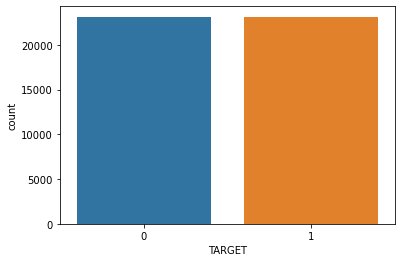

In [66]:
# Countplot da variável TARGET
sns.countplot(x = treino_y_balanceado)
plt.show()

Resultado: Variável TARGET balanceada com o método SMOTE

## 6.0 - Feature Selection

#### Seleção de recursos com SelectKBest

In [67]:
kbest_f = SelectKBest(score_func=f_classif, k=6).fit(treino_x_balanceado, treino_y_balanceado)

In [68]:
x_pontos_variaveis = []
y_pontos_variaveis = []

for i in np.arange(0, len(kbest_f.scores_)):
    x_pontos_variaveis.append(treino_x.columns.values[i])
    y_pontos_variaveis.append(np.round(kbest_f.scores_[i], 2))
    
kbest_f_df = pd.DataFrame({"Variavel": x_pontos_variaveis, "Score": y_pontos_variaveis}).sort_values("Score", ascending=False).reset_index().drop("index", axis = 1)

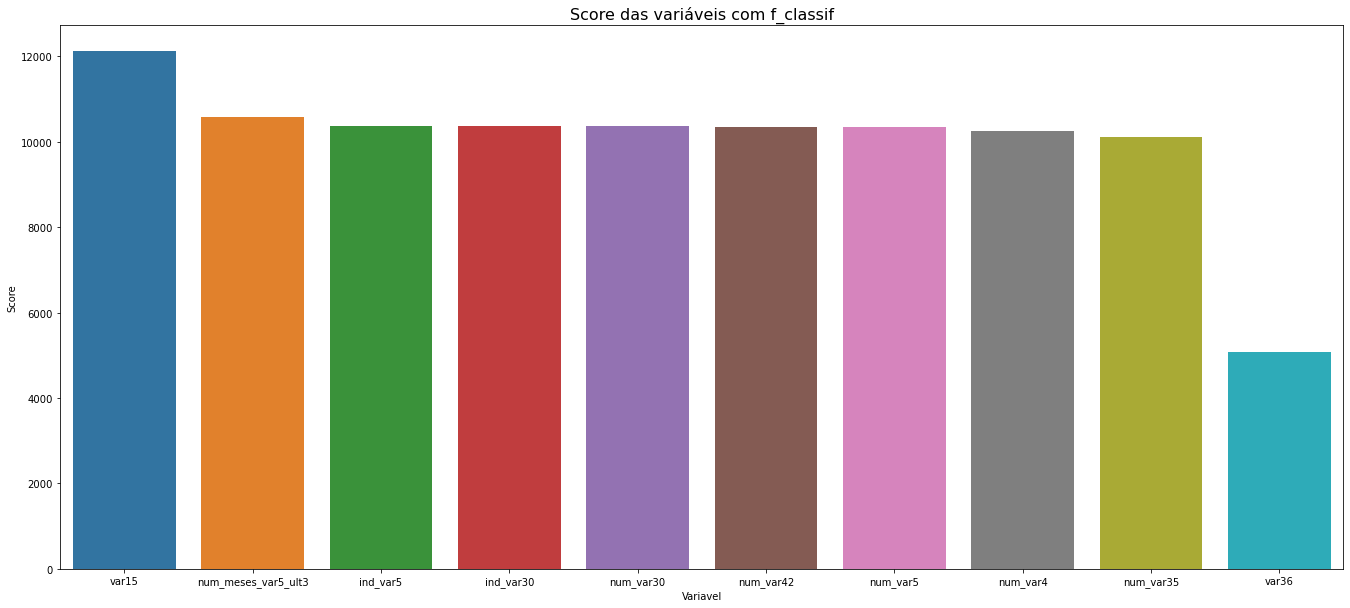

In [69]:
# Plot do score das variaveis com f_classif
figure = plt.figure(figsize=(23,10))
sns.barplot(x = "Variavel", y = "Score", data = kbest_f_df[0:10])
plt.title("Score das variáveis com f_classif", fontdict = {'fontsize': 16})
plt.show()

#### Seleção de recursos com RandomForest

In [70]:
kbest_cat = ExtraTreesClassifier(n_estimators=100).fit(treino_x_balanceado, treino_y_balanceado)

In [71]:
x_pontos_variaveis = []
y_pontos_variaveis = []

for i in np.arange(0, len(kbest_cat.feature_importances_)):
    x_pontos_variaveis.append(treino_x.columns.values[i])
    y_pontos_variaveis.append(np.round(kbest_cat.feature_importances_[i], 2))
    
kbest_cat_df = pd.DataFrame({"Variavel": x_pontos_variaveis, "Score": y_pontos_variaveis}).sort_values("Score", ascending=False).reset_index().drop("index", axis = 1)

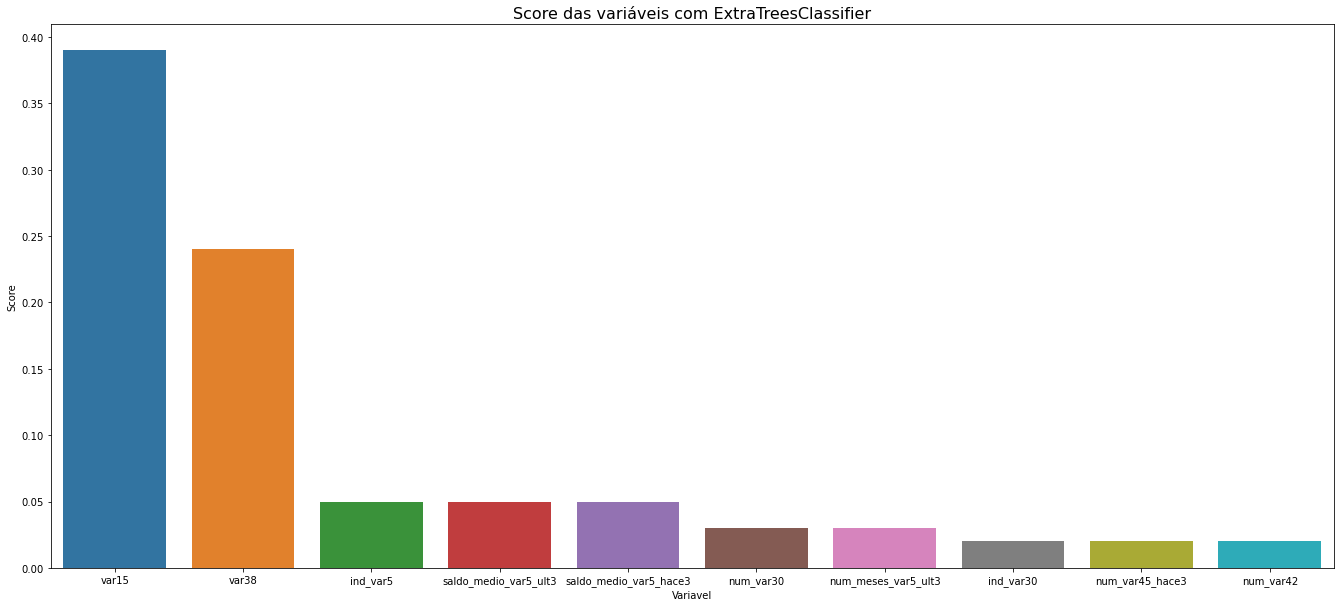

In [72]:
# Plot do score das variaveis com ExtraTreesClassifier
figure = plt.figure(figsize=(23,10))
sns.barplot(x = "Variavel", y = "Score", data = kbest_cat_df[0:10])
plt.title("Score das variáveis com ExtraTreesClassifier", fontdict = {'fontsize': 16})
plt.show()

#### Selecionando as variáveis com score maior que 1000 do SelectKBest com f_classif

In [73]:
selecao_variaveis = kbest_f_df[ kbest_f_df["Score"] > 1000.00 ].Variavel

In [74]:
# Filtrar dados de treino e teste X com as melhores variáveis (Utilizado ExtraTreesClassifier)
treino_x_balanceado = treino_x_balanceado[selecao_variaveis]
teste_x = teste_x[selecao_variaveis]

In [75]:
treino_x_balanceado.head()

,var15,num_meses_var5_ult3,ind_var5,ind_var30,num_var30,num_var42,num_var5,num_var4,num_var35,var36,saldo_medio_var5_hace3,saldo_medio_var5_ult3,saldo_medio_var5_ult1,saldo_var42,saldo_var30,saldo_var5,saldo_medio_var5_hace2
0,-0.513695,3,1,1,3,3,3,1,0.845867,3,0.015162,-0.247672,-0.260276,-0.259671,-0.259671,-0.259056,-0.255256
1,-0.631867,3,1,1,3,3,3,1,0.845867,3,0.008393,-0.249230,-0.260276,-0.259671,-0.259671,-0.259056,-0.255256
2,-0.041009,3,1,1,3,3,3,1,0.845867,3,-0.370677,-0.277260,-0.260276,-0.259671,-0.259671,-0.259056,-0.255256
3,-0.631867,0,0,0,0,0,0,0,-1.170294,99,-0.411291,-0.384709,-0.377973,-0.376856,-0.376856,-0.376445,-0.379445
4,1.613394,0,0,0,0,0,0,0,-1.170294,99,-0.411291,-0.384709,-0.377973,-0.376856,-0.376856,-0.376445,-0.379445


#### Dataset de treino com 17 variáveis preditoras

## 7.0 - Treinamento e Avaliação do modelo de Machine Learning

#### Função para estruturar dados de teste para entrada do modelo de machine learning

In [76]:
def estruturar_dados(df):
    # Verificar se contem todas as colunas no dataset
    if ( False in np.isin(selecao_variaveis, df.columns) ):
        print("Não foi encontrada alguma das colunas necessárias no dataset, lista das colunas abaixo")
        print("Colunas:", selecao_variaveis)
        return None
    
    # Pegar somente as variáveis que contem no modelo
    df = df[selecao_variaveis]
    # Normalizar variáveis numéricas
    variaveis_para_normalizar = [i for i in df.columns if np.isin(i, variaveis_numericas_mung)]
    df[variaveis_para_normalizar] = StandardScaler().fit_transform(df[variaveis_para_normalizar])
    return df

#### Cross-Validation com modelos da lista + XGBoost

In [77]:
# Obtendo a lista de modelos
modelos_ml = obter_modelos()

In [78]:
# Treinando todos os modelos da lista (Cross-Validation)
for nome, modelo in modelos_ml:
    kfold = KFold(n_splits=5)
    modelo_crossval = cross_val_score(modelo, treino_x_balanceado, treino_y_balanceado, cv = kfold, scoring = "accuracy")
    msg = "%s: %f (%f)" % (nome, modelo_crossval.mean(), modelo_crossval.std())
    print( msg )

LR: 0.627738 (0.078809)
LDA: 0.630568 (0.074004)
NB: 0.708836 (0.095880)
KNN: 0.801858 (0.040845)
CART: 0.852128 (0.017910)
SVM: 0.585008 (0.069157)


In [79]:
# Treinamento com XGBoost (Cross-Validation)
modelo_xgb_cv = xgb.XGBClassifier()
treino_xgb = xgb.DMatrix(treino_x_balanceado, label = treino_y_balanceado)
param_xgb = {'objective':'reg:logistic'}

modelo_crossval = xgb.cv(param_xgb, treino_xgb, nfold=10,
       metrics={'error'}, seed=42)

print( "XGB:", np.round(1 - np.mean( modelo_crossval.to_dict()['test-error-mean'][1] ), 2) )

XGB: 0.83


#### Resultado: Os 3 melhores modelos foram KNN, CART e XGBoost

#### Treinamento e Avaliação do modelo Regressão Logística

In [80]:
# Treinar o modelo de Regressão Logística
modelo_lr = LogisticRegression()
modelo_lr.fit(treino_x_balanceado, treino_y_balanceado)

# Avaliar o modelo Regressão Logística com dados de teste
previsao_lr = modelo_lr.predict(teste_x)
metricas_modelo("Logistic Regression", teste_y, previsao_lr)

Modelo: Logistic Regression 

Confusion Matrix:
                Satisfeito  Não Satisfeito
Satisfeito            9059            2292
Não Satisfeito         145             473

Relatório de classificação:
                precision    recall  f1-score   support

    Satisfeito       0.98      0.80      0.88     11351
Não Satisfeito       0.17      0.77      0.28       618

      accuracy                           0.80     11969
     macro avg       0.58      0.78      0.58     11969
  weighted avg       0.94      0.80      0.85     11969



#### Treinamento e Avaliação do modelo KNN

In [81]:
# Treinar o modelo KNN
modelo_knn = KNeighborsClassifier()
modelo_knn.fit(treino_x_balanceado, treino_y_balanceado)

# Avaliar o modelo KNN com dados de teste
previsao_knn = modelo_knn.predict(teste_x)
metricas_modelo("KNN", teste_y, previsao_knn)

Modelo: KNN 

Confusion Matrix:
                Satisfeito  Não Satisfeito
Satisfeito            9832            1519
Não Satisfeito         309             309

Relatório de classificação:
                precision    recall  f1-score   support

    Satisfeito       0.97      0.87      0.91     11351
Não Satisfeito       0.17      0.50      0.25       618

      accuracy                           0.85     11969
     macro avg       0.57      0.68      0.58     11969
  weighted avg       0.93      0.85      0.88     11969



#### Treinamento e Avaliação do modelo CART

In [82]:
# Treinar o modelo CART
modelo_cart = DecisionTreeClassifier()
modelo_cart.fit(treino_x_balanceado, treino_y_balanceado)

# Avaliar o modelo CART com dados de teste
previsao_cart = modelo_cart.predict(teste_x)
metricas_modelo("CART", teste_y, previsao_cart)

Modelo: CART 

Confusion Matrix:
                Satisfeito  Não Satisfeito
Satisfeito            9863            1488
Não Satisfeito         267             351

Relatório de classificação:
                precision    recall  f1-score   support

    Satisfeito       0.97      0.87      0.92     11351
Não Satisfeito       0.19      0.57      0.29       618

      accuracy                           0.85     11969
     macro avg       0.58      0.72      0.60     11969
  weighted avg       0.93      0.85      0.89     11969



#### Treinamento e Avaliação do modelo SVM

In [83]:
# Treinar o modelo SVM
modelo_svm = SVC()
modelo_svm.fit(treino_x_balanceado, treino_y_balanceado)

# Avaliar o modelo SVM com dados de teste
previsao_svm = modelo_svm.predict(teste_x)
metricas_modelo("SVM", teste_y, previsao_svm)

Modelo: SVM 

Confusion Matrix:
                Satisfeito  Não Satisfeito
Satisfeito            6858            4493
Não Satisfeito          97             521

Relatório de classificação:
                precision    recall  f1-score   support

    Satisfeito       0.99      0.60      0.75     11351
Não Satisfeito       0.10      0.84      0.19       618

      accuracy                           0.62     11969
     macro avg       0.54      0.72      0.47     11969
  weighted avg       0.94      0.62      0.72     11969



#### Treinamento e Avaliação do modelo XGBoost

In [84]:
# Treinar o modelo XGBoost
teste_xgb = xgb.DMatrix(teste_x, teste_y)
modelo_xgb = xgb.train(param_xgb, treino_xgb)

# Avaliar o modelo XGBoost com dados de teste
previsao_xgb = modelo_xgb.predict(teste_xgb)
metricas_modelo("XGB", teste_y, np.around(previsao_xgb))

Modelo: XGB 

Confusion Matrix:
                Satisfeito  Não Satisfeito
Satisfeito            9437            1914
Não Satisfeito         189             429

Relatório de classificação:
                precision    recall  f1-score   support

    Satisfeito       0.98      0.83      0.90     11351
Não Satisfeito       0.18      0.69      0.29       618

      accuracy                           0.82     11969
     macro avg       0.58      0.76      0.59     11969
  weighted avg       0.94      0.82      0.87     11969



#### Resultado: Entre os modelos treinados, os modelos escolhidos para otimização são Regressão Linear e XGBoost porque apresentaram uma boa acurácia e recall

## 8.0 - Otimização do modelo de Machine Learning

#### Otimizar modelo de Regressão Logística

In [85]:
grid = {
    "solver": ["newton-cg", "lbfgs", "liblinear", "sag", "saga"],
    "penalty": ["none", "l1", "l2", "elasticnet"],
    "C": [100, 10, 1.0, 0.1, 0.01]
}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(LogisticRegression(), param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(treino_x_balanceado, treino_y_balanceado)

print("Melhor: %f use %s" % (grid_result.best_score_, grid_result.best_params_))

Melhor: 0.779765 use {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}


In [86]:
# Treinar o modelo de Regressão Logística Otimizado
modelo_lr_otimizado = LogisticRegression(C = 0.1, penalty = 'l2', solver = 'lbfgs')
modelo_lr_otimizado.fit(treino_x_balanceado, treino_y_balanceado)


# Avaliar o modelo Regressão Logística Otimizado com dados de teste
previsao_lr_otimizado = grid_result.predict(teste_x)
metricas_modelo("Logistic Regression Otimizado", teste_y, previsao_lr_otimizado)

Modelo: Logistic Regression Otimizado 

Confusion Matrix:
                Satisfeito  Não Satisfeito
Satisfeito            9062            2289
Não Satisfeito         147             471

Relatório de classificação:
                precision    recall  f1-score   support

    Satisfeito       0.98      0.80      0.88     11351
Não Satisfeito       0.17      0.76      0.28       618

      accuracy                           0.80     11969
     macro avg       0.58      0.78      0.58     11969
  weighted avg       0.94      0.80      0.85     11969



#### Resultado: Tivemos uma melhora de 0.01 em recall otimizando o modelo de regressão linear

#### Otimizar modelo XGBoost

In [87]:
params = {'max_depth': [3,6,10], 
           'learning_rate': [0.01, 0.05, 0.1], 
           'n_estimators': [100, 500, 1000], 
           'colsample_bytree': [0,3, 0,7]}

xgbc = xgb.XGBClassifier(seed = 42, eval_metric = 'logloss')

grid_search = GridSearchCV(estimator = xgbc,
                          param_grid = params,
                          scoring = 'accuracy',
                          verbose = 1,
                          n_jobs = -1)

grid_result = grid_search.fit(treino_x_balanceado, treino_y_balanceado)
print("Melhor: %f use %s" % (grid_result.best_score_, grid_result.best_params_))

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Melhor: 0.885850 use {'colsample_bytree': 0, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 1000}


In [88]:
# Treinar o modelo XGBoost otimizado
modelo_xgb_otimizado = xgb.XGBClassifier(objective = 'reg:logistic',
                 eval_metric = 'logloss',
                 seed = 42,
                 colsample_bytree = 0,
                 learning_rate = 0.1,
                 max_depth = 10,
                 n_estimators = 1000)
                 
modelo_xgb_otimizado.fit(treino_x_balanceado, treino_y_balanceado)


# Avaliar o modelo XGBoost Otimizado com dados de teste
previsao_xgb_otimizado = grid_result.predict(teste_x)
metricas_modelo("XGBoost Otimizado", teste_y, np.around(previsao_xgb_otimizado))

Modelo: XGBoost Otimizado 

Confusion Matrix:
                Satisfeito  Não Satisfeito
Satisfeito            9773            1578
Não Satisfeito         228             390

Relatório de classificação:
                precision    recall  f1-score   support

    Satisfeito       0.98      0.86      0.92     11351
Não Satisfeito       0.20      0.63      0.30       618

      accuracy                           0.85     11969
     macro avg       0.59      0.75      0.61     11969
  weighted avg       0.94      0.85      0.88     11969



#### Resultado: Tivemos uma melhora de 0.03 de acurácia, porém tivemos uma perda de 0.01 em recall otimizando o XGBoost

### Testando perfomance dos modelos otimizados com dataset de teste disponibilizado no Kaggle (test.csv)

In [89]:
# Visualizar dataset de teste
dados_teste.head()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,imp_op_var41_comer_ult1,imp_op_var41_comer_ult3,imp_op_var41_efect_ult1,imp_op_var41_efect_ult3,imp_op_var41_ult1,imp_op_var39_efect_ult1,imp_op_var39_efect_ult3,imp_op_var39_ult1,imp_sal_var16_ult1,ind_var1_0,ind_var1,ind_var2_0,ind_var2,ind_var5_0,ind_var5,ind_var6_0,ind_var6,ind_var8_0,ind_var8,ind_var12_0,ind_var12,ind_var13_0,ind_var13_corto_0,ind_var13_corto,ind_var13_largo_0,ind_var13_largo,ind_var13_medio_0,ind_var13_medio,ind_var13,ind_var14_0,ind_var14,ind_var17_0,ind_var17,ind_var18_0,ind_var18,ind_var19,ind_var20_0,ind_var20,ind_var24_0,ind_var24,ind_var25_cte,ind_var26_0,ind_var26_cte,ind_var26,ind_var25_0,ind_var25,ind_var27_0,ind_var28_0,ind_var28,ind_var27,ind_var29_0,ind_var29,ind_var30_0,ind_var30,ind_var31_0,ind_var31,ind_var32_cte,ind_var32_0,ind_var32,ind_var33_0,ind_var33,ind_var34_0,ind_var34,ind_var37_cte,ind_var37_0,ind_var37,ind_var39_0,ind_var40_0,ind_var40,ind_var41_0,ind_var41,ind_var39,ind_var44_0,ind_var44,ind_var46_0,ind_var46,num_var1_0,num_var1,num_var4,num_var5_0,num_var5,num_var6_0,num_var6,num_var8_0,num_var8,num_var12_0,num_var12,num_var13_0,num_var13_corto_0,num_var13_corto,num_var13_largo_0,num_var13_largo,num_var13_medio_0,num_var13_medio,num_var13,num_var14_0,num_var14,num_var17_0,num_var17,num_var18_0,num_var18,num_var20_0,num_var20,num_var24_0,num_var24,num_var26_0,num_var26,num_var25_0,num_var25,num_op_var40_hace2,num_op_var40_hace3,num_op_var40_ult1,num_op_var40_ult3,num_op_var41_hace2,num_op_var41_hace3,num_op_var41_ult1,num_op_var41_ult3,num_op_var39_hace2,num_op_var39_hace3,num_op_var39_ult1,num_op_var39_ult3,num_var27_0,num_var28_0,num_var28,num_var27,num_var29_0,num_var29,num_var30_0,num_var30,num_var31_0,num_var31,num_var32_0,num_var32,num_var33_0,num_var33,num_var34_0,num_var34,num_var35,num_var37_med_ult2,num_var37_0,num_var37,num_var39_0,num_var40_0,num_var40,num_var41_0,num_var41,num_var39,num_var42_0,num_var42,num_var44_0,num_var44,num_var46_0,num_var46,saldo_var1,saldo_var5,saldo_var6,saldo_var8,saldo_var12,saldo_var13_corto,saldo_var13_largo,saldo_var13_medio,saldo_var13,saldo_var14,saldo_var17,saldo_var18,saldo_var20,saldo_var24,saldo_var26,saldo_var25,saldo_var28,saldo_var27,saldo_var29,saldo_var30,saldo_var31,saldo_var32,saldo_var33,saldo_var34,saldo_var37,saldo_var40,saldo_var41,saldo_var42,saldo_var44,saldo_var46,var36,delta_imp_amort_var18_1y3,delta_imp_amort_var34_1y3,delta_imp_aport_var13_1y3,delta_imp_aport_var17_1y3,delta_imp_aport_var33_1y3,delta_imp_compra_var44_1y3,delta_imp_reemb_var13_1y3,delta_imp_reemb_var17_1y3,delta_imp_reemb_var33_1y3,delta_imp_trasp_var17_in_1y3,delta_imp_trasp_var17_out_1y3,delta_imp_trasp_var33_in_1y3,delta_imp_trasp_var33_out_1y3,delta_imp_venta_var44_1y3,delta_num_aport_var13_1y3,delta_num_aport_var17_1y3,delta_num_aport_var33_1y3,delta_num_compra_var44_1y3,delta_num_reemb_var13_1y3,delta_num_reemb_var17_1y3,delta_num_reemb_var33_1y3,delta_num_trasp_var17_in_1y3,delta_num_trasp_var17_out_1y3,delta_num_trasp_var33_in_1y3,delta_num_trasp_var33_out_1y3,delta_num_venta_var44_1y3,imp_amort_var18_hace3,imp_amort_var18_ult1,imp_amort_var34_hace3,imp_amort_var34_ult1,imp_aport_var13_hace3,imp_aport_var13_ult1,imp_aport_var17_hace3,imp_aport_var17_ult1,imp_aport_var33_hace3,imp_aport_var33_ult1,imp_var7_emit_ult1,imp_var7_recib_ult1,imp_compra_var44_hace3,imp_compra_var44_ult1,imp_reemb_var13_hace3,imp_reemb_var13_ult1,imp_reemb_var17_hace3,imp_reemb_var17_ult1,imp_reemb_var33_hace3,imp_reemb_var33_ult1,imp_var43_emit_ult1,imp_trans_var37_ult1,imp_trasp_var17_in_hace3,imp_trasp_var17_in_ult1,imp_trasp_var17_out_hace3,imp_trasp_var17_out_ult1,imp_trasp_var33_in_hace3,imp_trasp_var33_in_ult1,imp_trasp_var33_out_hace3,imp_trasp_var33_out_ult1,imp_venta_var44_hace3,imp_venta_var44_ult1,ind_var7_emit_ult1,ind_var7_recib_ult1,ind_var10_ult1,ind_var10

#### Resultado: Dataset de teste disponibilizado pelo Kaggle, dados não estão estruturado para a entrada do modelo, vamos estruturar...

In [90]:
# Transformar dataset de teste para entrada dos modelos
dados_teste_mod = estruturar_dados(dados_teste)

In [91]:
# Visualizar dataset de teste tratado para entrada de dados dos modelos
dados_teste_mod.head()

,var15,num_meses_var5_ult3,ind_var5,ind_var30,num_var30,num_var42,num_var5,num_var4,num_var35,var36,saldo_medio_var5_hace3,saldo_medio_var5_ult3,saldo_medio_var5_ult1,saldo_var42,saldo_var30,saldo_var5,saldo_medio_var5_hace2
0,-0.088064,3,1,1,3,3,3,1,-0.106047,3,-0.120353,-0.129659,-0.107368,-0.139129,-0.213010,-0.100554,-0.134997
1,0.143920,3,1,1,3,3,3,1,-0.106047,3,-0.120337,-0.129899,-0.107675,-0.139184,-0.213056,-0.100861,-0.135246
2,-0.784016,3,1,1,3,3,3,2,0.938415,3,-0.113055,-0.122121,-0.102724,-0.138684,-0.212646,-0.098099,-0.128011
3,-0.706688,0,0,0,0,0,0,0,-1.150509,99,-0.120678,-0.130249,-0.107981,-0.139240,-0.213101,-0.101167,-0.135496
4,-0.784016,3,1,1,3,3,3,1,-0.106047,3,-0.120160,-0.127632,-0.104916,-0.138684,-0.212646,-0.098099,-0.133001


#### Resultado: Primeiras linha do dataset de teste com as variáveis preditores e variáveis numéricas normalizadas

#### Dataset de teste com Regressão Logística Otimizado

In [92]:
prever_dataset_teste_rl = modelo_lr_otimizado.predict(dados_teste_mod)
metricas_modelo("Dataset de teste: Regressão Logística", resultado_teste, prever_dataset_teste_rl)

Modelo: Dataset de teste: Regressão Logística 

Confusion Matrix:
                Satisfeito  Não Satisfeito
Satisfeito           64344           11474
Não Satisfeito           0               0

Relatório de classificação:
                precision    recall  f1-score   support

    Satisfeito       1.00      0.85      0.92     75818
Não Satisfeito       0.00      0.00      0.00         0

      accuracy                           0.85     75818
     macro avg       0.50      0.42      0.46     75818
  weighted avg       1.00      0.85      0.92     75818



#### Dataset de teste com XGBoost Otimizado

In [93]:
prever_dataset_teste_xgb = modelo_xgb_otimizado.predict(dados_teste_mod)
metricas_modelo("Dataset de teste: XGBoost", resultado_teste, prever_dataset_teste_xgb)

Modelo: Dataset de teste: XGBoost 

Confusion Matrix:
                Satisfeito  Não Satisfeito
Satisfeito            3782           72036
Não Satisfeito           0               0

Relatório de classificação:
                precision    recall  f1-score   support

    Satisfeito       1.00      0.05      0.10     75818
Não Satisfeito       0.00      0.00      0.00         0

      accuracy                           0.05     75818
     macro avg       0.50      0.02      0.05     75818
  weighted avg       1.00      0.05      0.10     75818



#### Resultado: Podemos observar os dois modelos otimizados com GridSearchCV, o modelo de Regressão Logística apresentou melhor performance comparado ao XGBoost, portanto o modelo de Regressão Logística será o modelo final para entrega do projeto.

## 9.0 - Salvar modelo de Machine Learning para entrega final do projeto

In [94]:
# Salvando modelo de regressão logística otimizado
caminho_modelo = "../modelo/ml_regressaoLogistica.sav"
pickle.dump(modelo_lr_otimizado, open(caminho_modelo, 'wb'))

### Resultado: Fim do projeto, foi proposto uma métrica de 70% de acurácia para o modelo de machine learning, o modelo entregue tem 85% de acurácia e uma boa taxa de recall, modelo foi testado com os dados de teste disponibilizado pelo Kaggle.